# <p style="text-align: center;"> **Bayesian Analysis of ARPAV time series on temperatures and precipitations**</p>
## <p style="text-align: center;">  Advanced Statistics for Physics Analysis Project - 17 July 2024</p>

**Students**: Cavezza Lorenzo, Longaroni Giacomo <br>
**Matricolas**: 2130648, 2126898

*ARPAV* (Agenzia Regionale per la iPrevenzione e Protezione Ambientale del Veneto) is an agency widespread over the territory that collects and analyzes environmental data. Some of the measurement points are quite old and a very long time serie (for example in Cavanis, Venice, daily measurements are available since 1900).
The aim of the project is to analyze the data available in three stations from 1993 to 2021, where the environment is quite different, and study the evolution over time. The stations are located in:<br>
- Auronzo di Cadore ( Lat: *46°33'33"* N, Long: *12°25'28"* E, Alt over sea level: 887 m);<br>
- Castelfranco Veneto ( Lat: *45°40'00"* N, Long: *11°55'00"* E, Alt over sea level: 46 m);<br>
- Porto Tolle ( Lat: *44°56'58"* N, Long: *12°19'28"* E, Alt over sea level: -22 m);<br>
- Roverchiara ( Lat: *45°16'10"* N, Long: *11°14'41"* E, Alt over sea level: 20 m).<br>

We start by importing the necessary R packages.

In [55]:
library(dplyr)
library(readr)
library(lubridate)
library(purrr)
library(tools)
library(ggplot2)
library(gridExtra)
library(stats)
library(R2jags)
library(coda)
library(forecast)
library(stringr)
library(MuMIn)

## **Storing The Dataset**

First, we define functions to read and store the dataset in dedicated R data frames using tidyverse tools. These functions provide datasets with daily, monthly, and annual measurements. The monthly and annual datasets were created by averaging daily data from all cities to provide the best overall description of temperature in Veneto.

In [2]:
create_dataset <- function(Monthly=FALSE,Yearly=FALSE) {
      
      data_folder <- "./datiarpav"
    
      file_csv <- list.files(path = data_folder, pattern = "*.csv", full.names = TRUE)    
      df <- file_csv |>
            map_df(~ read_csv(.x, show_col_types = FALSE) |>
            na.omit() |>
            mutate(file = file_path_sans_ext(basename(.x)),
                   month = ym(format(date, "%Y-%m")),
                   year_only = year(date))) |>
            filter(date >= as.Date('1993-01-01') & date <= as.Date('2021-12-31')) |>
            relocate( month, year_only, file, .after = date) |>
            arrange(date)     

      #Better format the stations' names
      df['file'][[1]]<-case_when(
          str_detect(df['file'][[1]],'Temperatura') == 1 ~ str_replace_all(str_replace_all(str_sub(df['file'][[1]],1,-23),"[:digit:]", ""),"_",""),
          str_detect(df['file'][[1]],'Temperatura') == 0 ~ str_to_lower(str_replace_all(str_replace_all(str_sub(df['file'][[1]],1,-9),"[:digit:]", ""),"_",""))
      )  
    
      # Aggiungere colonne year e month_only
      df <- df |>
            mutate(month_only = as.double(format(month, "%m"))) |>
            relocate(month_only, .after = year_only)

      # dataset con summary mensili
      if(Monthly){
            df <- df |> group_by(month) |> summarise(MIN_mean = mean(TMIN), MED_mean = mean(TMED), MAX_mean = mean(TMAX)) |> 
                  mutate(year_only = as.double(format(month, "%Y")), month_only = as.double(format(month, "%m")))|>
            relocate(month_only, year_only, .after = month)
      }
      # dataset con summary annuali 
      if(Yearly){
            df <- df |> group_by(year_only) |> summarise(MIN_mean = mean(TMIN), MED_mean = mean(TMED), MAX_mean = mean(TMAX)) |> mutate(x_fit = year_only - min(year_only))
      }
      
    return(df)
}

month_analisis <- function(df, n){
      m_df <- df[df$month_only == n,]
      return(m_df)
}



In [3]:
daily_dataset <- create_dataset()
monthly_dataset <- create_dataset(Monthly =   TRUE) 
yearly_dataset <- create_dataset(Yearly = TRUE)
head(daily_dataset,3)
head(monthly_dataset,3)
head(yearly_dataset,3)

date,month,year_only,month_only,file,TMIN,TMED,TMAX
<date>,<date>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
1993-01-01,1993-01-01,1993,1,Porto Tolle - Pradon,-0.3,2.6604,4.7
1993-01-01,1993-01-01,1993,1,Castelfranco Veneto,-7.5,-2.5677,4.7
1993-01-01,1993-01-01,1993,1,Roverchiara,-4.9,-1.3302,3.9


month,month_only,year_only,MIN_mean,MED_mean,MAX_mean
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1993-01-01,1,1993,-2.7709677,0.7212567,4.888940
1993-02-01,2,1993,-3.7118518,2.0787911,8.875138
1993-03-01,3,1993,0.2251634,5.5080083,11.212235


year_only,MIN_mean,MED_mean,MAX_mean,x_fit
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1993,6.279188,11.29433,16.70935,0
1994,7.493069,12.33045,17.57927,1
1995,6.181094,11.16600,16.58323,2


## **Preliminary Analysis**


We will begin our analysis with a preliminary study of the minimum, average, and maximum temperatures from month to month to see if there is any kind of correlation or trend over the 1993-2021 study period; the following functions provide a visualization of the monthly temperature as a classic line graph and with a heatmap describing the temperature change for a single month compared to the average temperature for the previous 10 years, then from the heatmap we can create a normal distribution in order lo get some information from the mean and the sd

In [4]:
# monthly heatmap
create_heatmap <- function(df, str, index){
    time_interval = 10              # past months to consider for the difference
    years <- unique(df$year_only)   
    num_years <- length(years)
    heatmap_data <- data.frame()
    
    for (n in 1:12) {
        month_evolution <- month_analisis(df, n)      # estraiamo una summary dei mesi 
        if(names(str)[index] == 'Minimum'){
            month_temp <- month_evolution$MIN_mean     # estraiamo solo la temperatura     
        }  
        else if(names(str)[index] == 'Maximum'){
            month_temp <- month_evolution$MAX_mean     
        }    
        else(names(str)[index] == 'Average')
            month_temp <- month_evolution$MED_mean 
        
        diff <- c()
        
        for (t in (time_interval+1):length(month_temp)) {         # computiamo la differenza tra temperatura di un anno e la media dei 10 anni precedenti
            t_mean <- mean(month_temp[(t-time_interval):(t-1)])
            diff_i <- month_temp[t] - t_mean
            diff <- c(diff, diff_i)
        }
        
        temp_df <- data.frame(                        # costruiamo la heatmap 
            Month = rep(n, length(diff)),
            Year = month_evolution$year_only[(time_interval+1):length(month_temp)],
            Difference = diff
        )
        heatmap_data <- rbind(heatmap_data, temp_df)
    }
    
    # plot 
    heatmap_plot <- ggplot(heatmap_data, aes(x = Year, y = Month, fill = Difference)) +
        geom_tile() +
        scale_fill_gradient2(low = "navy", mid = "white", high = "orange", midpoint = 0) +
        labs(title = paste(names(str)[index], "Monthly T. difference w.r.t. 10 years before"),
             x = "Year",
             y = "Month",
             fill = "Difference") +
        theme_bw()+
        theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))


    return(list(heatmap_plot, heatmap_data, mean(heatmap_data$Difference),var(heatmap_data$Difference)))
}

#Temperature difference distribution
norm_plot <- function(mean,var,type,index){
  x_axis = seq(-5,5,0.001)
  dist = dnorm(x=x_axis,sd = sqrt(var), mean = mean)
  df <- data.frame(x = x_axis, y = dist)
  p <- ggplot(df, aes(x = x, y = y)) + 
  geom_line(color = type[[index]], linewidth = 2) + 
  geom_vline(aes(xintercept = mean), linetype = 2) +
  theme_bw()+
  labs(title = paste(names(type)[index],'Temperature Difference Distribution '),
       x = 'Temperature (°C)',
       y = 'Density') + 
  theme_bw() +
  theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))
 return (p)
}

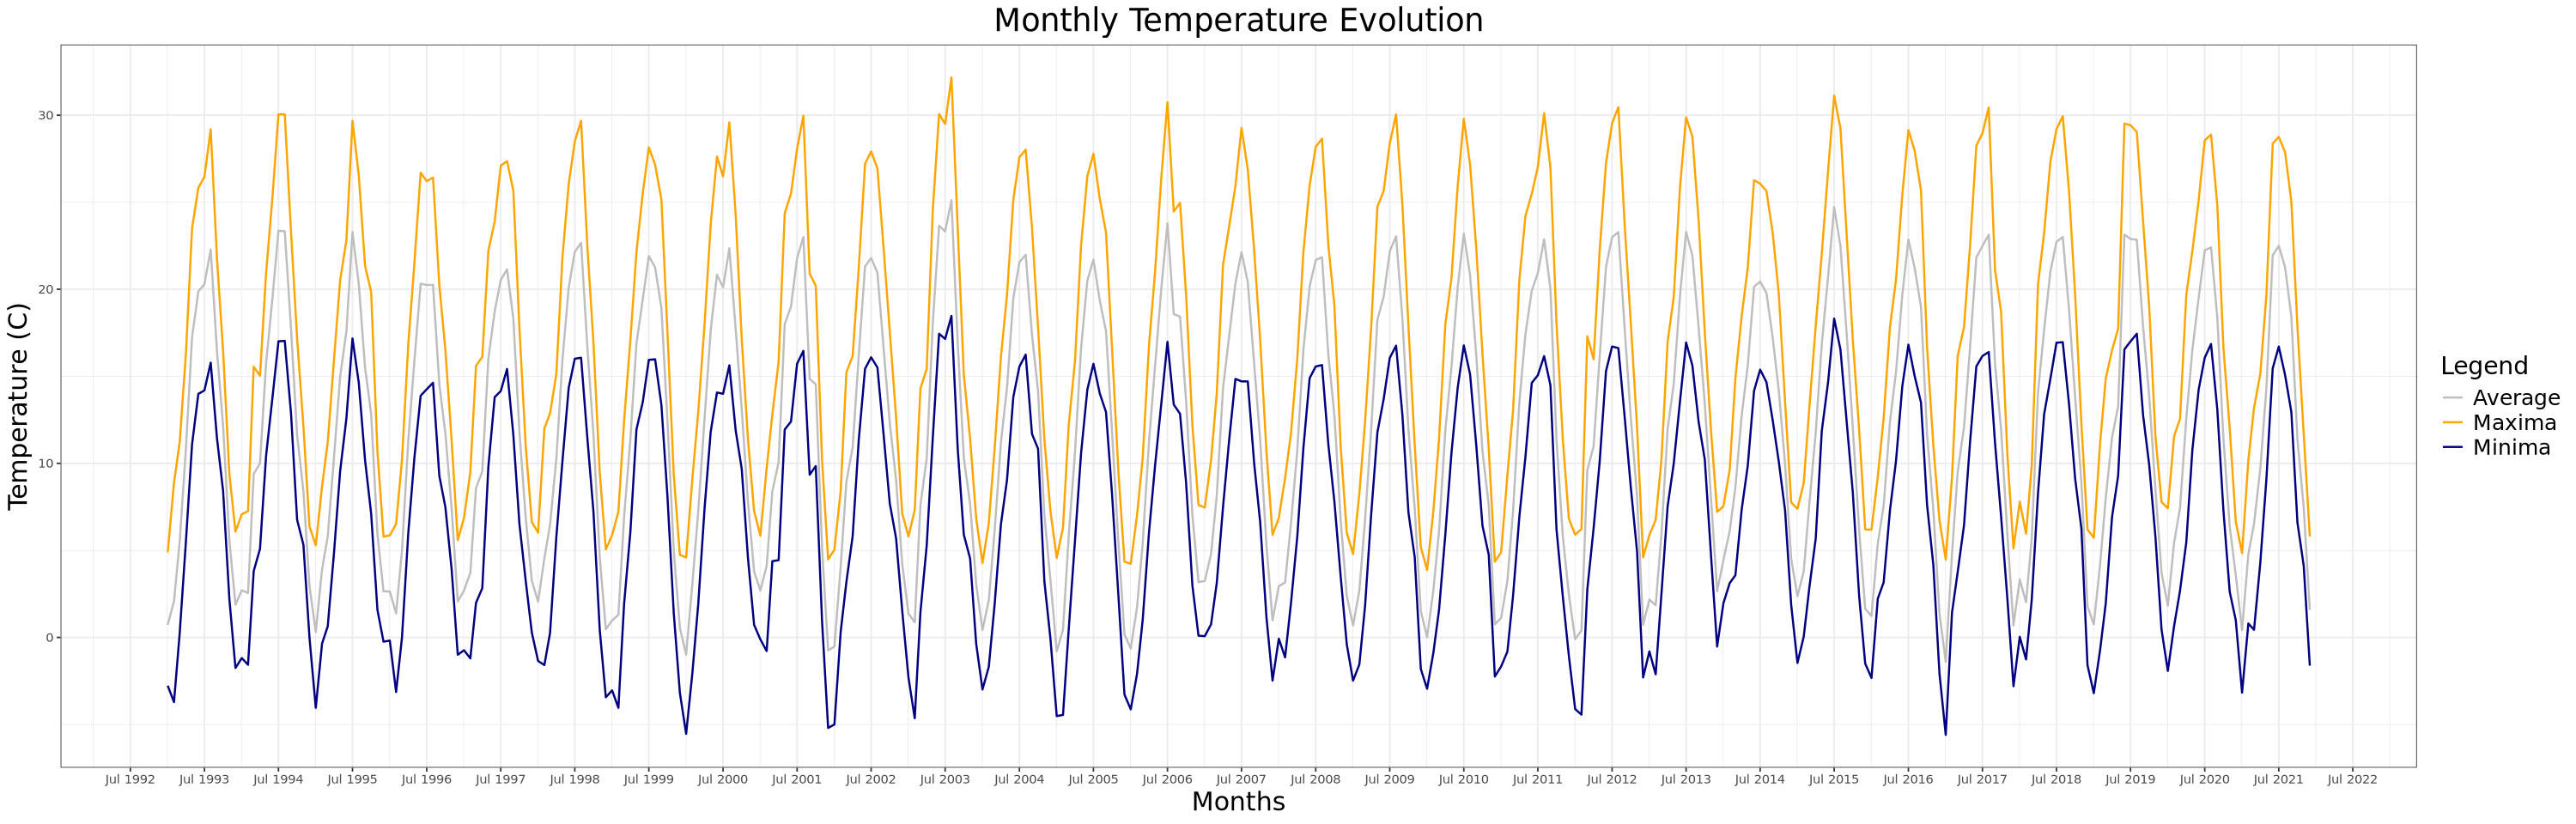

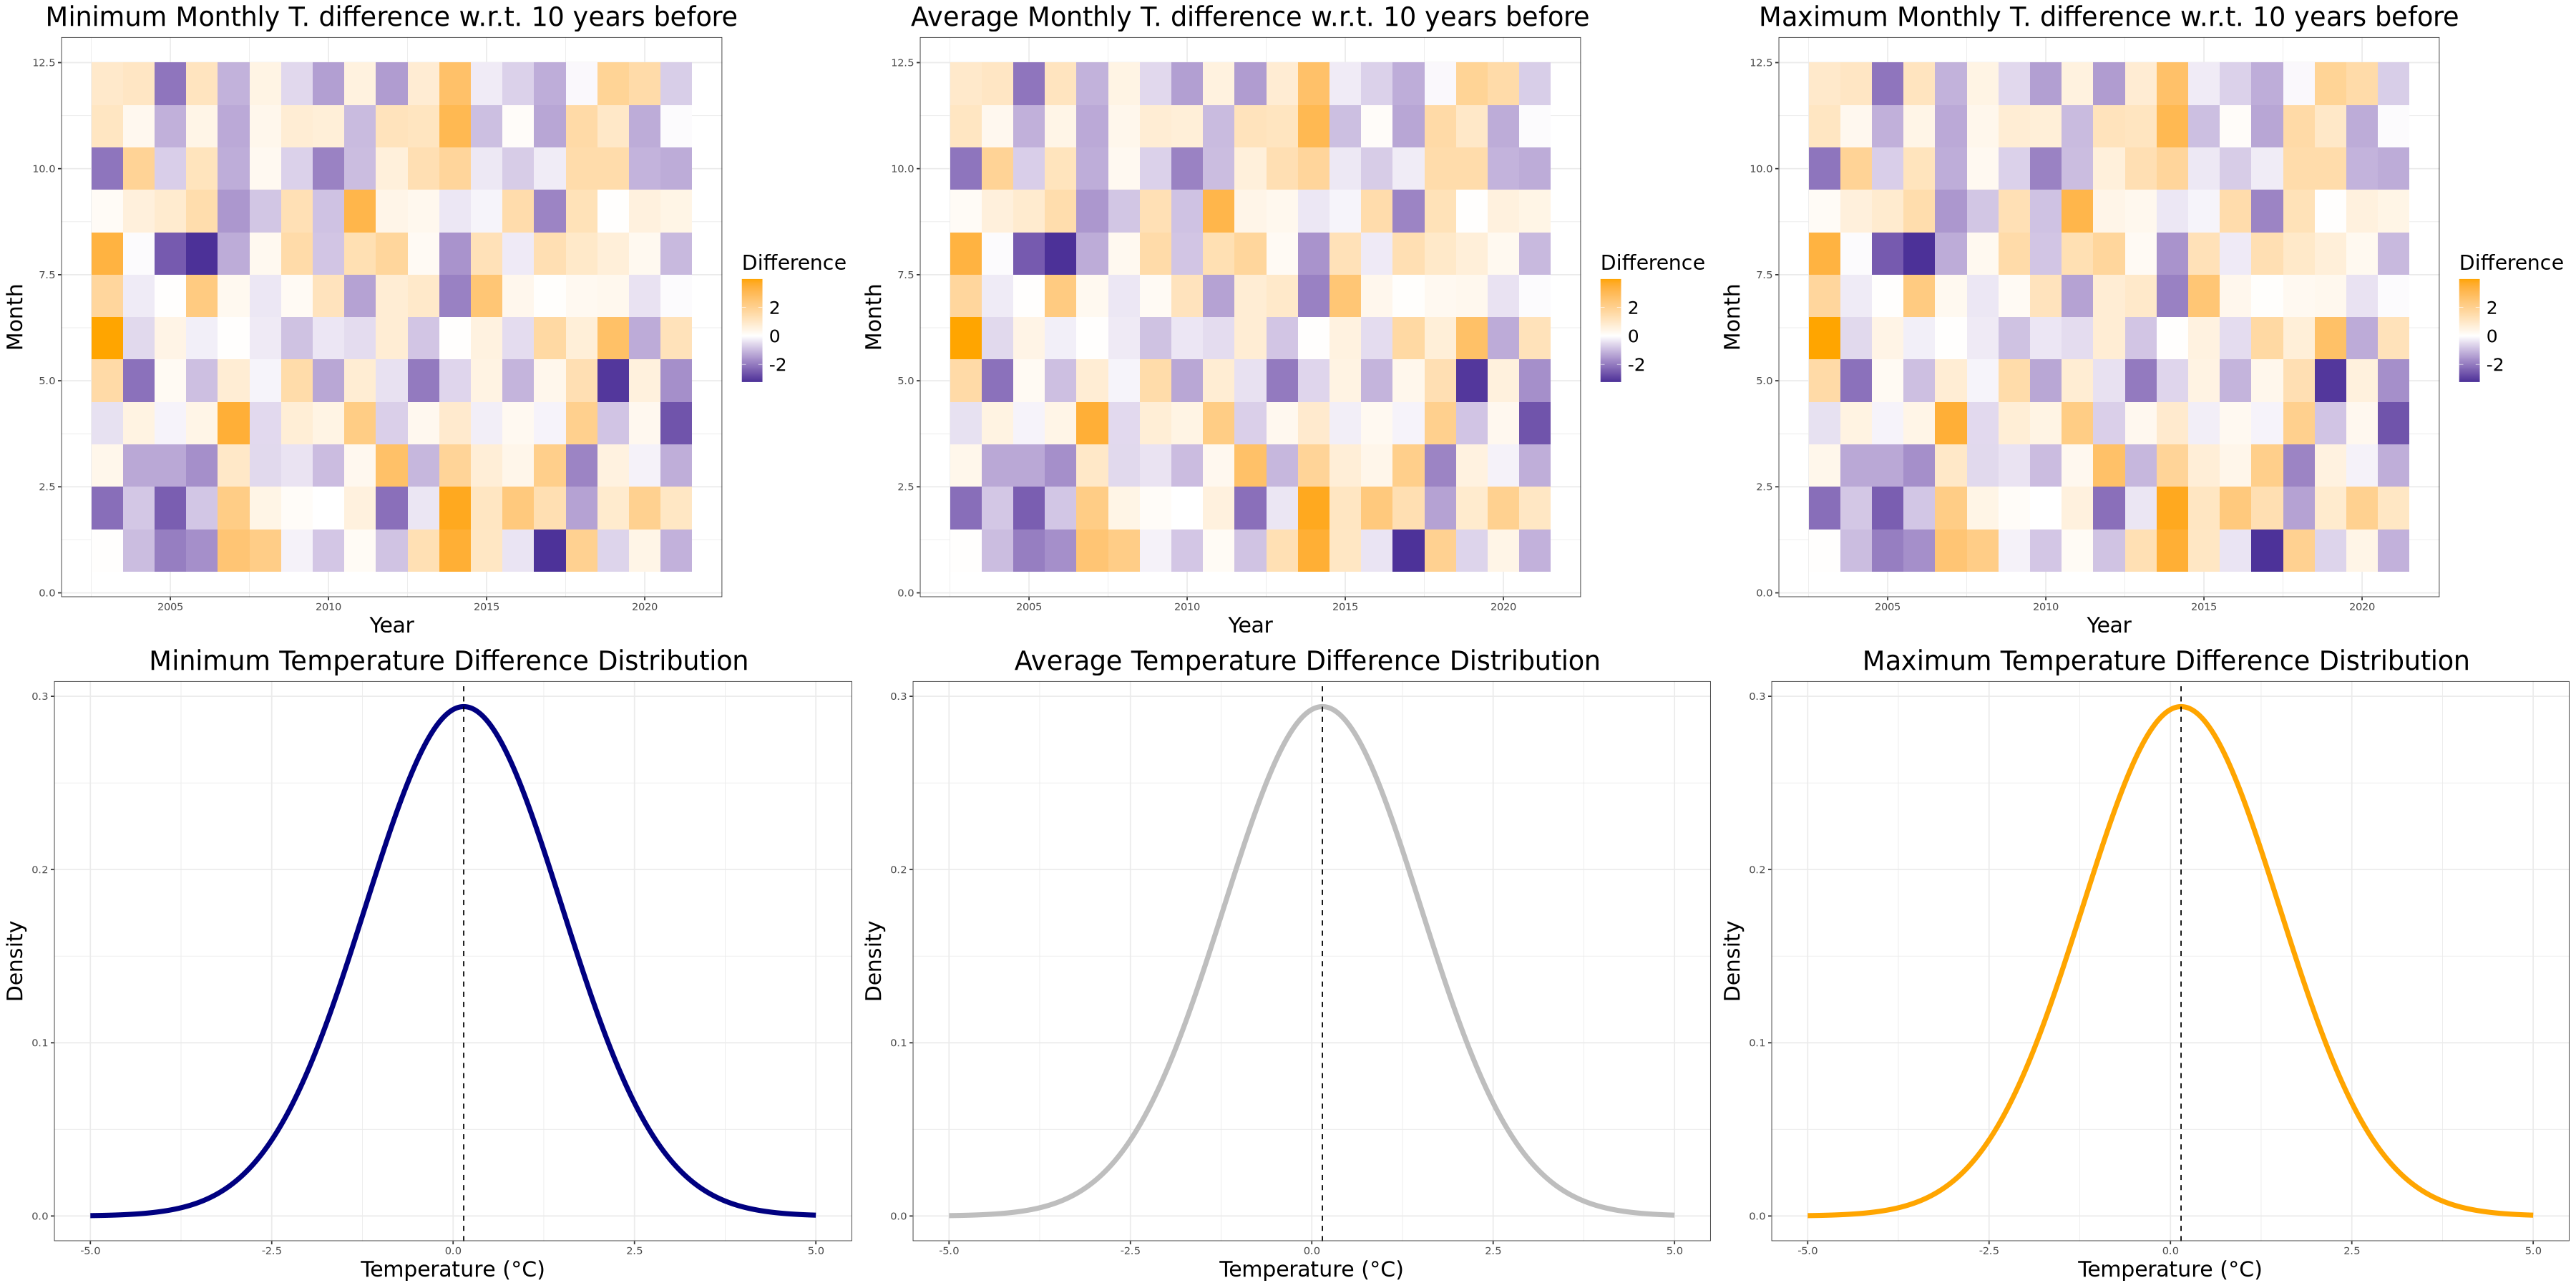

In [5]:
# Setting plot size
options(repr.plot.width = 25, repr.plot.height = 8)

# Monthly Plot
p_m <- ggplot(data = monthly_dataset) +
  geom_line(aes(x = month, y = MED_mean, color = 'Average'), group = 1, linewidth = 0.7) +
  geom_line(aes(x = month, y = MIN_mean, color = 'Minima'), group = 1, linewidth = 0.7) +
  geom_line(aes(x = month, y = MAX_mean, color = 'Maxima'), group = 1, linewidth = 0.7) +
  scale_color_manual(name = 'Legend', values = c('Minima' = 'navy', 'Maxima' = 'orange', 'Average' = 'gray')) +
  labs(title = 'Monthly Temperature Evolution',
       x = 'Months',
       y = 'Temperature (C)') +
  scale_x_date(date_breaks = "12 month", date_labels = "%b %Y") +
  theme_bw() +
  theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))

print(p_m)

par<-c('Minimum'='navy','Average'='gray','Maximum'='orange')
#Heatmap creation
h_min <- create_heatmap(df = monthly_dataset, str = par,index=1)
h_ava <- create_heatmap(df = monthly_dataset, str = par,index=2)
h_max <- create_heatmap(df = monthly_dataset, str = par,index=3)


#Normal plotting
plot_min <- norm_plot(h_min[[3]],h_min[[4]],type=par,index=1)
plot_ava <- norm_plot(h_ava[[3]],h_ava[[4]],type=par,index=2)
plot_max <- norm_plot(h_max[[3]],h_max[[4]],type=par,index=3)

options(repr.plot.width = 30, repr.plot.height = 15)
grid.arrange(h_min[[1]], h_ava[[1]], h_max[[1]], 
             plot_min, plot_ava, plot_max, 
             ncol = 3, nrow = 2)

It is clear that we cannot be sure at all that an increasing trend is present, as even if the mean is positive the variance is too big to tell.<br> Further statistical investigations are neede to assess the time series trend.

## **Annual Average Evolution Analysis**

We proceed the analysis with an annual average approach, the study is performed over the yearly dataset, as the previous section we first look at the data including in the plot the mean of the timeseries

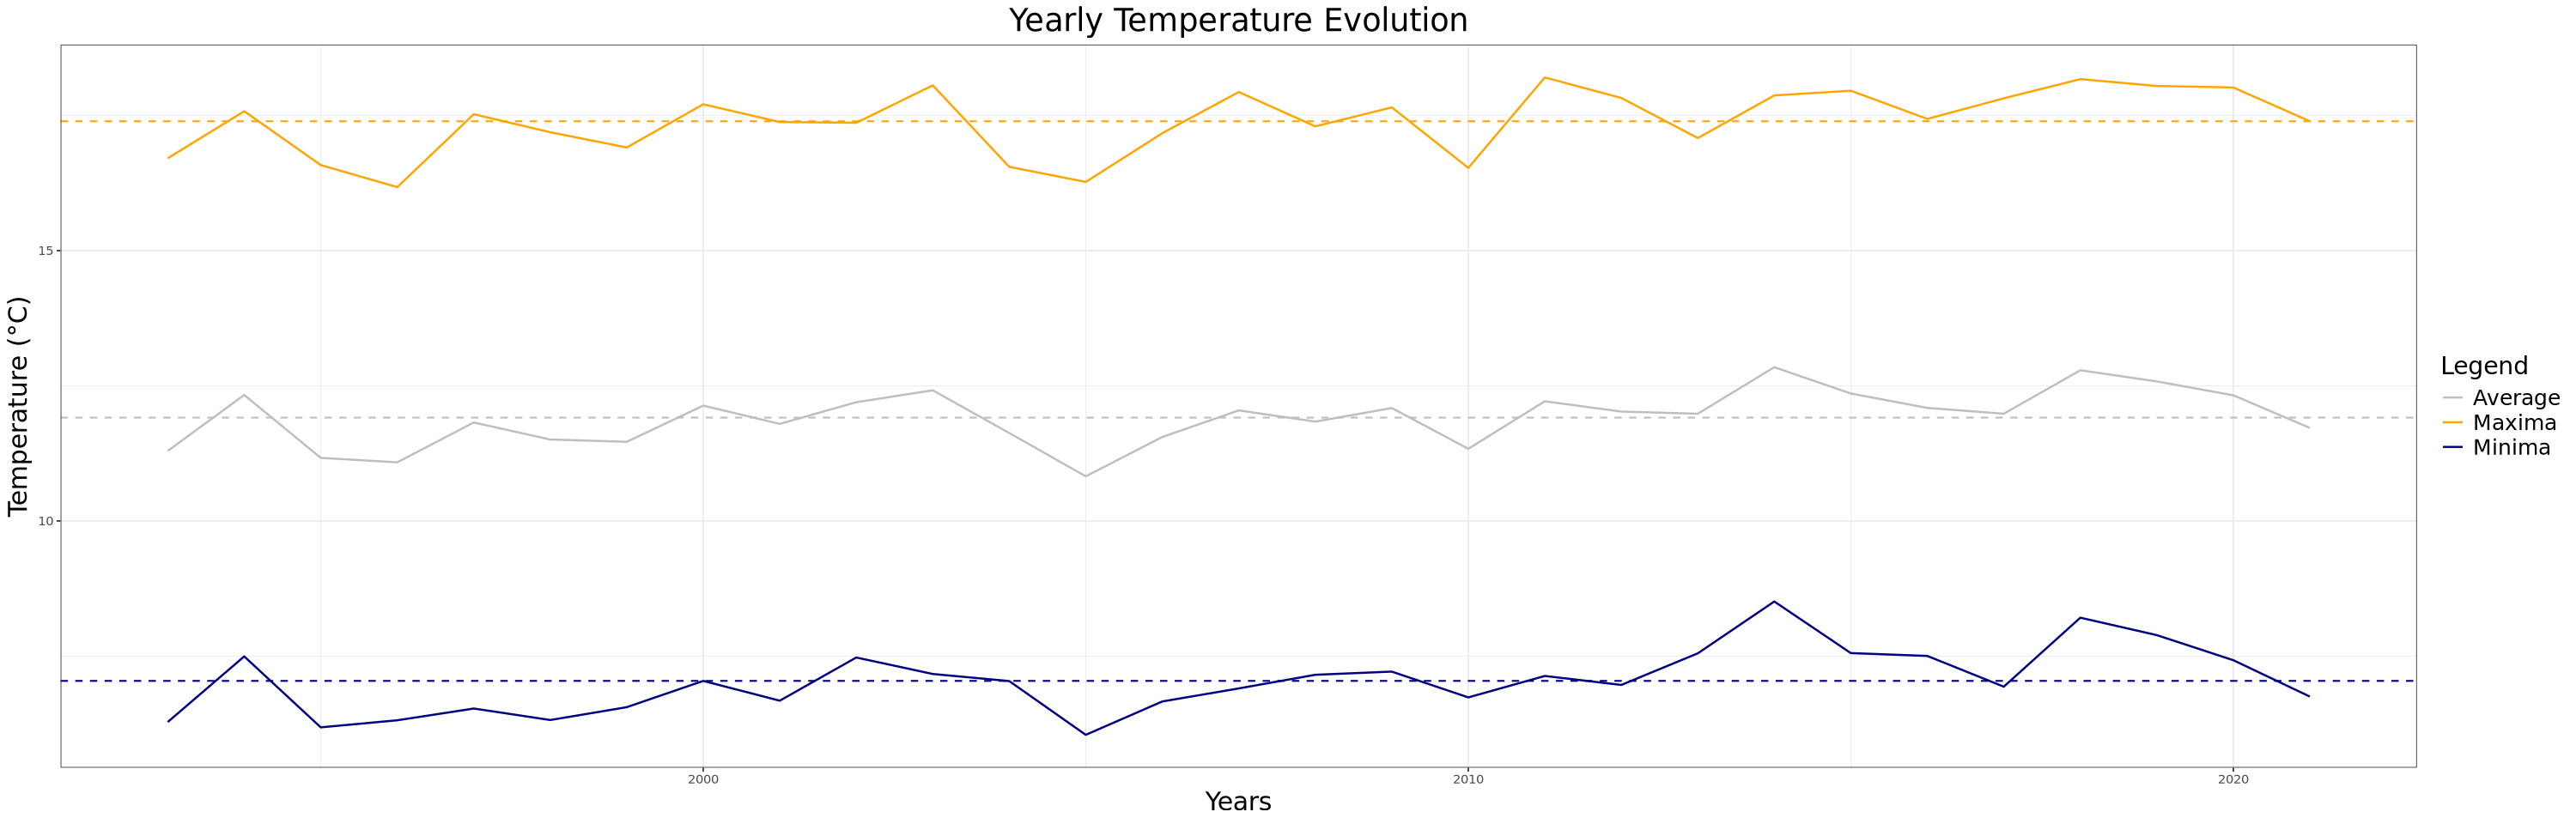

In [6]:
options(repr.plot.width = 25, repr.plot.height = 8)
# Annual Trend
p_y <- ggplot(data = yearly_dataset) +
  geom_line(aes(x = year_only, y = MED_mean, color = 'Average'), group = 1, linewidth = 0.7) +
  geom_hline(aes(yintercept= mean(MED_mean)), color = 'gray', linewidth = 0.6, linetype = 2)+
  geom_line(aes(x = year_only, y = MIN_mean, color = 'Minima'), group = 1, linewidth = 0.7) +
  geom_hline(aes(yintercept= mean(MIN_mean)), color = 'navy', linewidth = 0.6, linetype = 2)+
  geom_line(aes(x = year_only, y = MAX_mean, color = 'Maxima'), group = 1, linewidth = 0.7) +
  geom_hline(aes(yintercept= mean(MAX_mean)), color = 'orange', linewidth = 0.6, linetype = 2)+  
  scale_color_manual(name = 'Legend', values = c('Minima' = 'navy', 'Maxima' = 'orange', 'Average' = 'gray')) +
  labs(title = 'Yearly Temperature Evolution',
       x = 'Years',
       y = 'Temperature (°C)') +
  theme_bw() +
  theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))

print(p_y)

A slight rising trend can be observed, particularly for the minima. So we decide to study the time series by fittind the data (avarage tearly temperature) with an costant values and with a linear regression, for the regression we use the tools provided in the stats library

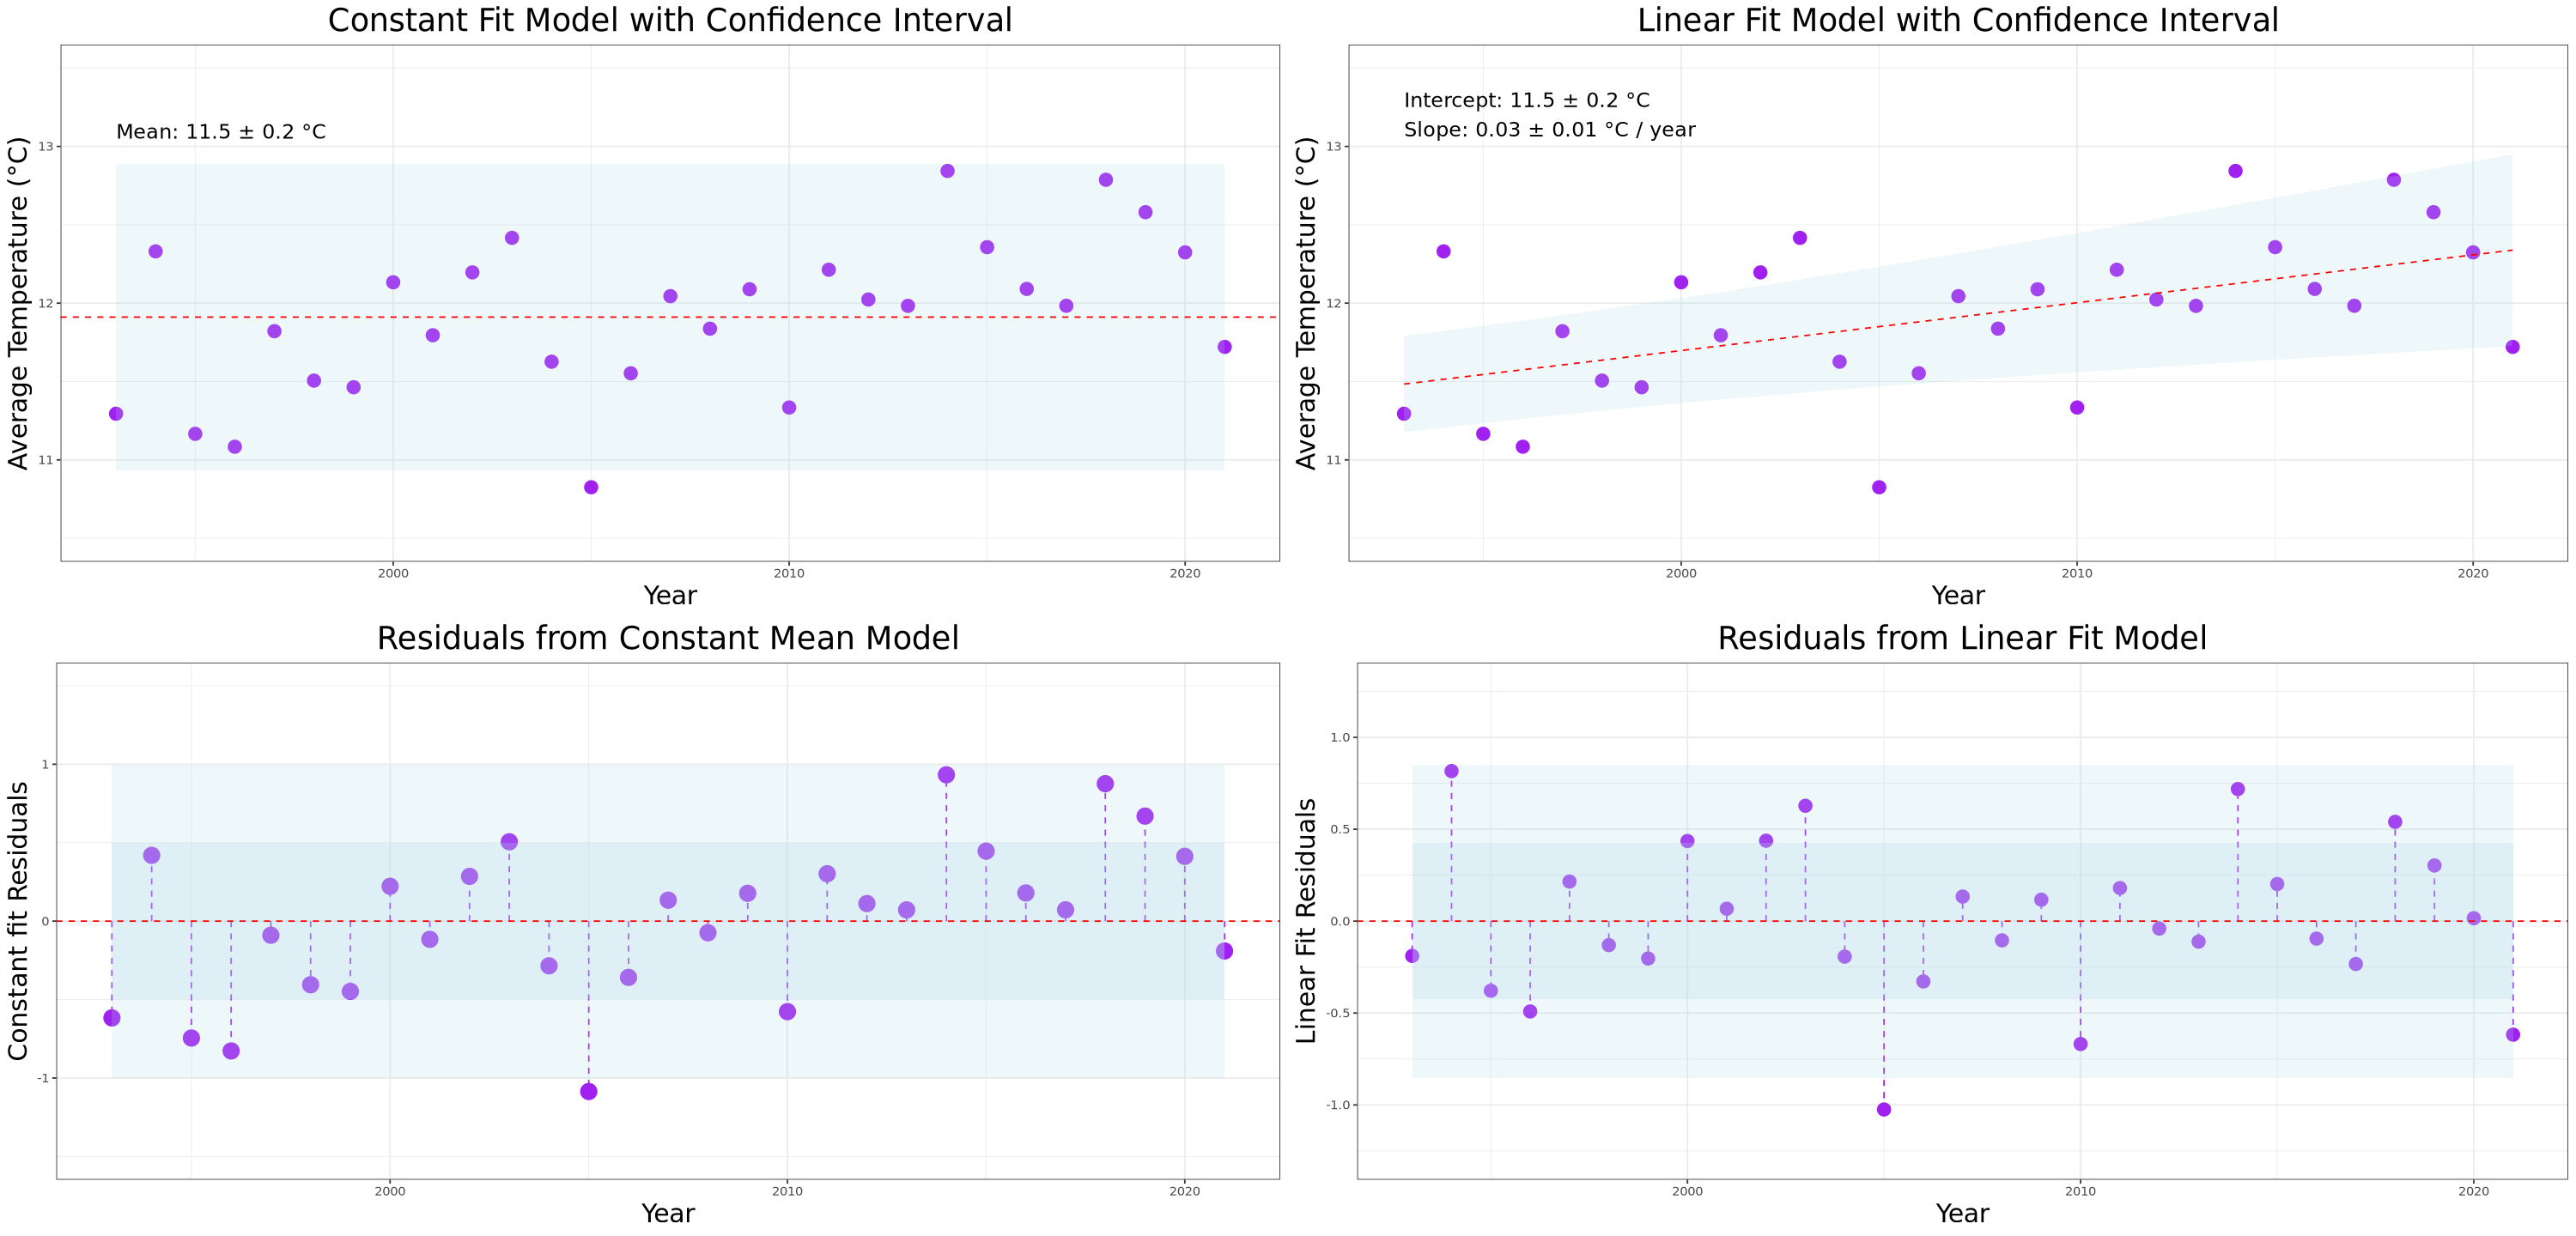

In [7]:
model <- lm(MED_mean ~ x_fit, data = yearly_dataset)
model_summary <- summary(model)
model_coeff_err <- coef(model_summary)[, "Std. Error"]
model_coeff <- coef(model_summary)[, 'Estimate']


fit_dataframe <- yearly_dataset |>
  select(year_only, MED_mean) |>
  mutate(linear_residuals = model$residuals) |>
  mutate(const_residuals = MED_mean - mean(MED_mean)) |>
  mutate(fitted_linear = model$fitted.values)

fit_dataframe <- fit_dataframe |>
  mutate(conf_lower = fitted_linear - 1.96 * sqrt((model_coeff_err[2] * yearly_dataset$x_fit)^2 + (model_coeff_err[1])^2),
         conf_upper = fitted_linear + 1.96 * sqrt((model_coeff_err[2] * yearly_dataset$x_fit)^2 + (model_coeff_err[1])^2)) |>
  mutate(x_fit = yearly_dataset$x_fit)


#constant_fit_text <- paste0("mean: ", round(mean(yearly_dataset$MED_mean), 1), 
                           # "\nsd: ", round(sqrt(var(yearly_dataset$MED_mean)), 1))
constant_fit_text <- paste0("Mean: ", round(model_coeff[1], 1), ' \u00B1 ', round(model_coeff_err[1], 1),' °C')

p_a <- ggplot(data = fit_dataframe) +
  geom_point(aes(x = year_only, y = MED_mean), col = 'purple', size = 4) +
  geom_ribbon(aes(x = year_only, ymin = mean(MED_mean) - 1.96*sqrt(var(MED_mean)), 
                  ymax = mean(MED_mean) + 1.96*sqrt(var(MED_mean))), 
              alpha = 0.2, fill = 'lightblue') +
  geom_hline(aes(yintercept = mean(MED_mean)), linetype = 2, color = 'red') +
  theme_minimal() +
  ylim(10.5, 13.5) +
  annotate("text", x = min(fit_dataframe$year_only), y = max(fit_dataframe$MED_mean) + 0.3, 
           label = constant_fit_text, hjust = 0, vjust = 1, size = 5, color = 'black') +
  labs(title = "Constant Fit Model with Confidence Interval",
       x = "Year",
       y = "Average Temperature (°C)")+
  theme_bw() +
  theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))


linear_fit_text <- paste0("Intercept: ", round(model_coeff[1], 1), ' \u00B1 ', round(model_coeff_err[1], 1),' °C', 
                          "\nSlope: ", round(model_coeff[2], 2), ' \u00B1 ', round(model_coeff_err[2], 2),' °C / year')

p_b <- ggplot(data = fit_dataframe) +
  geom_point(aes(x = year_only, y = MED_mean), col = 'purple', size = 4) +
  geom_ribbon(aes(x = year_only, ymin = conf_lower, ymax = conf_upper), alpha = 0.2, fill = 'lightblue') +
  geom_line(aes(x = year_only, y = fitted_linear), linetype = 2, col = 'red') +
  theme_minimal() +
  ylim(10.5, 13.5) +
  annotate("text", x = min(fit_dataframe$year_only), y = max(fit_dataframe$MED_mean) + 0.5, 
           label = linear_fit_text, hjust = 0, vjust = 1, size = 5, color = "black") +
  labs(title = "Linear Fit Model with Confidence Interval",
       x = "Year",
       y = "Average Temperature (°C)")+
  theme_bw() +
  theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))

p_c <- ggplot(data = fit_dataframe) +
  geom_point(aes(x = year_only, y = const_residuals), col = 'purple', size = 5) +
  geom_segment(aes(x = year_only, xend = year_only, y = 0, yend = const_residuals), linetype = 2, color = 'purple') +
  geom_ribbon(aes(x = year_only, ymin = sqrt(var(MED_mean)), ymax = -sqrt(var(MED_mean))), alpha = 0.4, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = sqrt(var(MED_mean)), ymax = 2*sqrt(var(MED_mean))), alpha = 0.2, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = 2*sqrt(var(MED_mean)), ymax = 3*sqrt(var(MED_mean))), alpha = 0., fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = -2*sqrt(var(MED_mean)), ymax = -sqrt(var(MED_mean))), alpha = 0.2, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = -3*sqrt(var(MED_mean)), ymax = -2*sqrt(var(MED_mean))), alpha = 0., fill = 'lightblue') +
  geom_hline(aes(yintercept = 0), linetype = 2, color = 'red') +
  theme_minimal() +
  labs(title = "Residuals from Constant Mean Model",
       x = "Year",
       y = "Constant fit Residuals")+
  theme_bw() +
  theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))


p_d <- ggplot(data = fit_dataframe) +
  geom_point(aes(x = year_only, y = linear_residuals), col = 'purple', size = 4) +
  geom_segment(aes(x = year_only, xend = year_only, y = 0, yend = linear_residuals), linetype = 2, color = 'purple') +
  geom_ribbon(aes(x = year_only, ymin = sqrt(var(linear_residuals)), ymax = -sqrt(var(linear_residuals))), alpha = 0.4, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = sqrt(var(linear_residuals)), ymax = 2 * sqrt(var(linear_residuals))), alpha = 0.2, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = 2 * sqrt(var(linear_residuals)), ymax = 3 * sqrt(var(linear_residuals))), alpha = 0.0, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = -2 * sqrt(var(linear_residuals)), ymax = -sqrt(var(linear_residuals))), alpha = 0.2, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = -3 * sqrt(var(linear_residuals)), ymax = -2 * sqrt(var(linear_residuals))), alpha = 0.0, fill = 'lightblue') +
  geom_hline(aes(yintercept = 0), linetype = 2, color = 'red') +
  theme_minimal() +
  labs(title = "Residuals from Linear Fit Model",
       x = "Year",
       y = "Linear Fit Residuals")+
  theme_bw() +
  theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))

options(repr.plot.width = 25, repr.plot.height = 12)


grid.arrange(p_a, p_b, p_c, p_d, 
             ncol = 2, nrow = 2)


From these initial fits, and particularly from their residuals, we can see that a linear trend appears to be more likely, as the residuals for the linear models appear to be more random, whereas we can see a slight rising trend in the ones from the constant model.<br>


The next step is to perform these fits once again this time simulating the parameters using a Monte Carlo Markov Chain with the *r-jags* package. We assume the evolution of the yearly temperature to be described by a normal distribution, then we can define two different models, one constant and one linear, based on the mean of the distribution.

-  $M_1 : T  \sim \mathcal{N}(\mu_1, \sigma_1) : \mu_1 = a_1$ 
-  $M_2 : T \sim \mathcal{N}(\mu_2, \sigma_2) : \mu_2 = a_2 + b x$

Using *r-jags*, we fit the models by sampling different $\{a,b,\sigma\}$ to find an approximate distribution of these parameters. We will then try to determine if one of the models can better describe the observed data, the following function will provide to perform the analysis using jags.


In [17]:
init_variables <- function(model_name) {
    if (model_name == "lin_model") {
        return( list(a_min = runif(1, -20, 20), b_min = runif(1, -0.5, 0.5), sigma_min = runif(1, 0, 0.8),
                     a_max = runif(1, -20, 20), b_max = runif(1, -0.5, 0.5), sigma_max = runif(1, 0, 0.8),
                     a_ava = runif(1, -20, 20), b_ava = runif(1, -0.5, 0.5), sigma_ava = runif(1, 0, 0.8)))
    } else if (model_name == "const_model") {
        return( list(a_min = runif(1, -20, 20), sigma_min = runif(1, 0, 0.8),
                     a_max = runif(1, -20, 20), sigma_max = runif(1, 0, 0.8),
                     a_ava = runif(1, -20, 20), sigma_ava = runif(1, 0, 0.8)))
    }
}

regression <- function(df, model_file, params) {
    data <- df %>% select(x_fit, MAX_mean, MIN_mean, MED_mean)
    inits <- init_variables(gsub(".jags", "", model_file))
    jm <- jags.model(model_file, data, inits, n.chains = 1, n.adapt = 1000)
    update(jm, n.iter = 50000)
    chain <- coda.samples(jm, params, n.iter = 1e6, thin = 20)
    return(chain)
}


density_plot<- function(chain, type, temp){
    options(repr.plot.width = 20, repr.plot.height = 6)
    chain_df <- as.data.frame(as.mcmc(chain)) 
    quantiles <- summary(chain)$quantiles[,c('2.5%','97.5%')]

    a <- paste('a_', temp, sep='')
    b <- paste('b_', temp, sep='')
    sigma <- paste('sigma_', temp, sep='')
    
    lower_a <- quantiles[a, '2.5%']
    upper_a <- quantiles[a, '97.5%']
    a <- chain_df[[a]]
    density_a <- density(a, n=2024)
    density_x <-   density_a[['x']]
    density_y <-   density_a[['y']]
    df <- data.frame(x = density_x, y = density_y)
    plot_a <- ggplot(df, aes(x = x, y = y)) +
        geom_line( color = 'navy') +
        geom_area(data = subset(df, x >= lower_a & x <= upper_a), aes(x = x, y = y), fill = 'lightblue', alpha = 0.5) +
        geom_vline(aes(xintercept = mean(a)), linetype = 2) +
        labs(title = paste("Posterior Distribution of a"),
             x = 'a',
             y = "Density") +
        theme_bw() +
    theme(plot.title = element_text(size = 22, hjust = 0.5),
    axis.title = element_text(size = 18),
    legend.text = element_text(size = 15),
    legend.title = element_text(size = 17))
 

    lower_sigma <- quantiles[sigma, '2.5%']
    upper_sigma <- quantiles[sigma, '97.5%']
    sigma <- chain_df[[sigma]]
    density_sigma <- density(sigma, n=2024)
    density_x <-   density_sigma[['x']]
    density_y <-   density_sigma[['y']]
    df <- data.frame(x = density_x, y = density_y)
    plot_sigma <- ggplot(df, aes(x = x, y = y)) +
        geom_line( color = 'navy') +
        geom_area(data = subset(df, x >= lower_sigma & x <= upper_sigma), aes(x = x, y = y), fill = 'lightblue', alpha = 0.5) +
        geom_vline(aes(xintercept = mean(sigma)), linetype = 2) +
        labs(title = paste("Posterior Distribution of σ"),
             x = 'σ',
             y = "Density") +
        theme_bw() +
    theme(plot.title = element_text(size = 22, hjust = 0.5),
    axis.title = element_text(size = 18),
    legend.text = element_text(size = 15),
    legend.title = element_text(size = 17))


    if(type == 'linear'){

        lower_b <- quantiles[b, '2.5%']
        upper_b <- quantiles[b, '97.5%']

        b <- chain_df[[b]]
        density_b <- density(b, n=2024)
        density_x <-   density_b[['x']]
        density_y <-   density_b[['y']]

        df <- data.frame(x = density_x, y = density_y)
        plot_b <- ggplot(df, aes(x = x, y = y)) +
            geom_line( color = 'navy') +
            geom_area(data = subset(df, x >= lower_b & x <= upper_b), aes(x = x, y = y), fill = 'lightblue', alpha = 0.5) +
            geom_vline(aes(xintercept = mean(b)), linetype = 2) +
            labs(title = paste("Posterior Distribution of b"),
                 x = 'b',
                 y = "Density") +
            theme_bw() +
        theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))

        return(grid.arrange(plot_a, plot_b, plot_sigma, ncol = 3, nrow = 1))
    } else {
        return(grid.arrange(plot_a, plot_sigma, ncol = 2, nrow = 1))
    }
}


trace_plot <- function(chain, type, temp) {
    options(repr.plot.width = 20, repr.plot.height = 8)
    chain_df <- as.data.frame(as.mcmc(chain)) 
    chain_df$iteration <- 1:length(chain_df[,1])

    a <- paste('a_', temp, sep='')
    b <- paste('b_', temp, sep='')
    sigma <- paste('sigma_', temp, sep='')
      
    if(type == 'linear'){
        
        plot_a <- ggplot(chain_df, aes_string(x = 1:nrow(chain_df), y = a)) +
            geom_line(alpha = 0.9, color = 'lightblue') +
            labs(title = paste("Trace Plot of a"),
                x = "Iteration",
                y = 'a') +
            theme_bw() +
        theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))

        plot_sigma <- ggplot(chain_df, aes_string(x = 1:nrow(chain_df),  y = sigma)) +
            geom_line(alpha = 0.9, color = 'lightblue') +
            labs(title = paste("Trace Plot of σ"),
                x = "Iteration",
                y = expression(sigma)) +
            theme_bw() +
        theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))
        options(repr.plot.width = 25, repr.plot.height = 7)

        if(type == 'linear'){
            plot_b <- ggplot(chain_df, aes_string(x = 1:nrow(chain_df),  y = b)) +
                geom_line(alpha = 0.9, color = 'lightblue') +
                labs(title = paste("Trace Plot of b"),
                    x = "Iteration",
                    y = 'b') +
                theme_bw() +
        theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))
            return(grid.arrange(plot_a, plot_b, plot_sigma, ncol = 3, nrow = 1))       
        }
        else {
            return(grid.arrange(plot_a, plot_sigma, ncol = 2, nrow = 1))
        }
    }
}


get_model_parameters <- function(chain, type, temp) {
    if(temp == 'min'){  
        chain_df <- as.data.frame( as.mcmc(chain) ) 
        if(type == 'linear'){
            parameters <- list(a = mean(chain_df$a_min), b = mean(chain_df$b_min), sigma = mean(chain_df$sigma_min),
                               sd_a = sd(chain_df$a_min), sd_b = sd(chain_df$b_min), sd_sigma= sd(chain_df$sigma_min) )
            return(parameters)
        }
        else if(type == 'constant'){
            parameters <- list(a = mean(chain_df$a_min), sigma = mean(chain_df$sigma_min),
                               sd_a = sd(chain_df$a_min),  sd_sigma= sd(chain_df$sigma_min) ) 
            return(parameters)
        }
    }
    else if(temp == 'max'){  
        chain_df <- as.data.frame( as.mcmc(chain) ) 
        if(type == 'linear'){
            parameters <- list(a = mean(chain_df$a_max), b = mean(chain_df$b_max), sigma = mean(chain_df$sigma_max),
                               sd_a = sd(chain_df$a_max), sd_b = sd(chain_df$b_max), sd_sigma= sd(chain_df$sigma_max) )
            return(parameters)
        }
        else if(type == 'constant'){
            parameters <- list(a = mean(chain_df$a_max), sigma = mean(chain_df$sigma_max),
                               sd_a = sd(chain_df$a_max),  sd_sigma= sd(chain_df$sigma_max) ) 
            return(parameters)
        }
    }
    else if(temp == 'ava'){  
        chain_df <- as.data.frame( as.mcmc(chain) ) 
        if(type == 'linear'){
            parameters <- list(a = mean(chain_df$a_ava), b = mean(chain_df$b_ava), sigma = mean(chain_df$sigma_ava),
                               sd_a = sd(chain_df$a_ava), sd_b = sd(chain_df$b_ava), sd_sigma= sd(chain_df$sigma_ava) )
            return(parameters)
        }
        else if(type == 'constant'){
            parameters <- list(a = mean(chain_df$a_ava), sigma = mean(chain_df$sigma_ava),
                               sd_a = sd(chain_df$a_ava),  sd_sigma= sd(chain_df$sigma_ava) ) 
            return(parameters)
        }
    }        
}

get_model_prediction <- function(chain, dataset, type, temp){

    if(type == 'linear'){
        parameters <- get_model_parameters(chain,type = 'linear', temp)
        y_pred <- parameters$a + (parameters$b * dataset$x_fit)        
    }
    else if(type == 'constant'){
        parameters <- get_model_parameters(chain,type = 'constant', temp)
        y_pred <- rep(parameters$a, length(dataset$x_fit))
    }
    return(y_pred)
}

get_model_likelihood <- function(chain, dataset, type, temp){
    param <- get_model_parameters(chain, type, temp)
    pred <- get_model_prediction(chain, dataset, type, temp)

    if(temp == 'min'){
        obs <- dataset$MIN_mean
    }
    else if(temp == 'max'){
        obs <- dataset$MAX_mean
    }
    else if(temp == 'ava'){
        obs <- dataset$MED_mean
    }
    return(-((log(param$sigma) * length(pred)) + sum(((obs - pred) / (sqrt(2) * param$sigma))^2)))
}

# Parametri per i modelli
lin_model_file <- "lin_model.jags"
lin_pars <- c("a_min", "b_min", "sigma_min", "a_max", "b_max", "sigma_max", "a_ava", "b_ava", "sigma_ava")

const_model_file <- "const_model.jags"
const_pars <- c("a_min", "sigma_min", "a_max", "sigma_max", "a_ava", "sigma_ava")


We can now run the Markov chain

In [9]:
lin_chain <- regression(yearly_dataset, lin_model_file, lin_pars)
const_chain <- regression(yearly_dataset, const_model_file, const_pars)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 87
   Unobserved stochastic nodes: 9
   Total graph size: 314

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 87
   Unobserved stochastic nodes: 6
   Total graph size: 135

Initializing model



Here we have obtained the approximated posterior distribution of the parameters of the model, we breafly recall the physical meaning:
- $a$ is the intercept of the fit (the initial value of the mean temperature starting from 1993).
- $b$ is the most interesting parameter: the slope of the linear regression, this values describe the increasing or decreasing of the temperature every year.
- $\sigma$ is the sd of the model likelihood 

Here we show the distribution with confidential intervall and the traceplot of the chain.

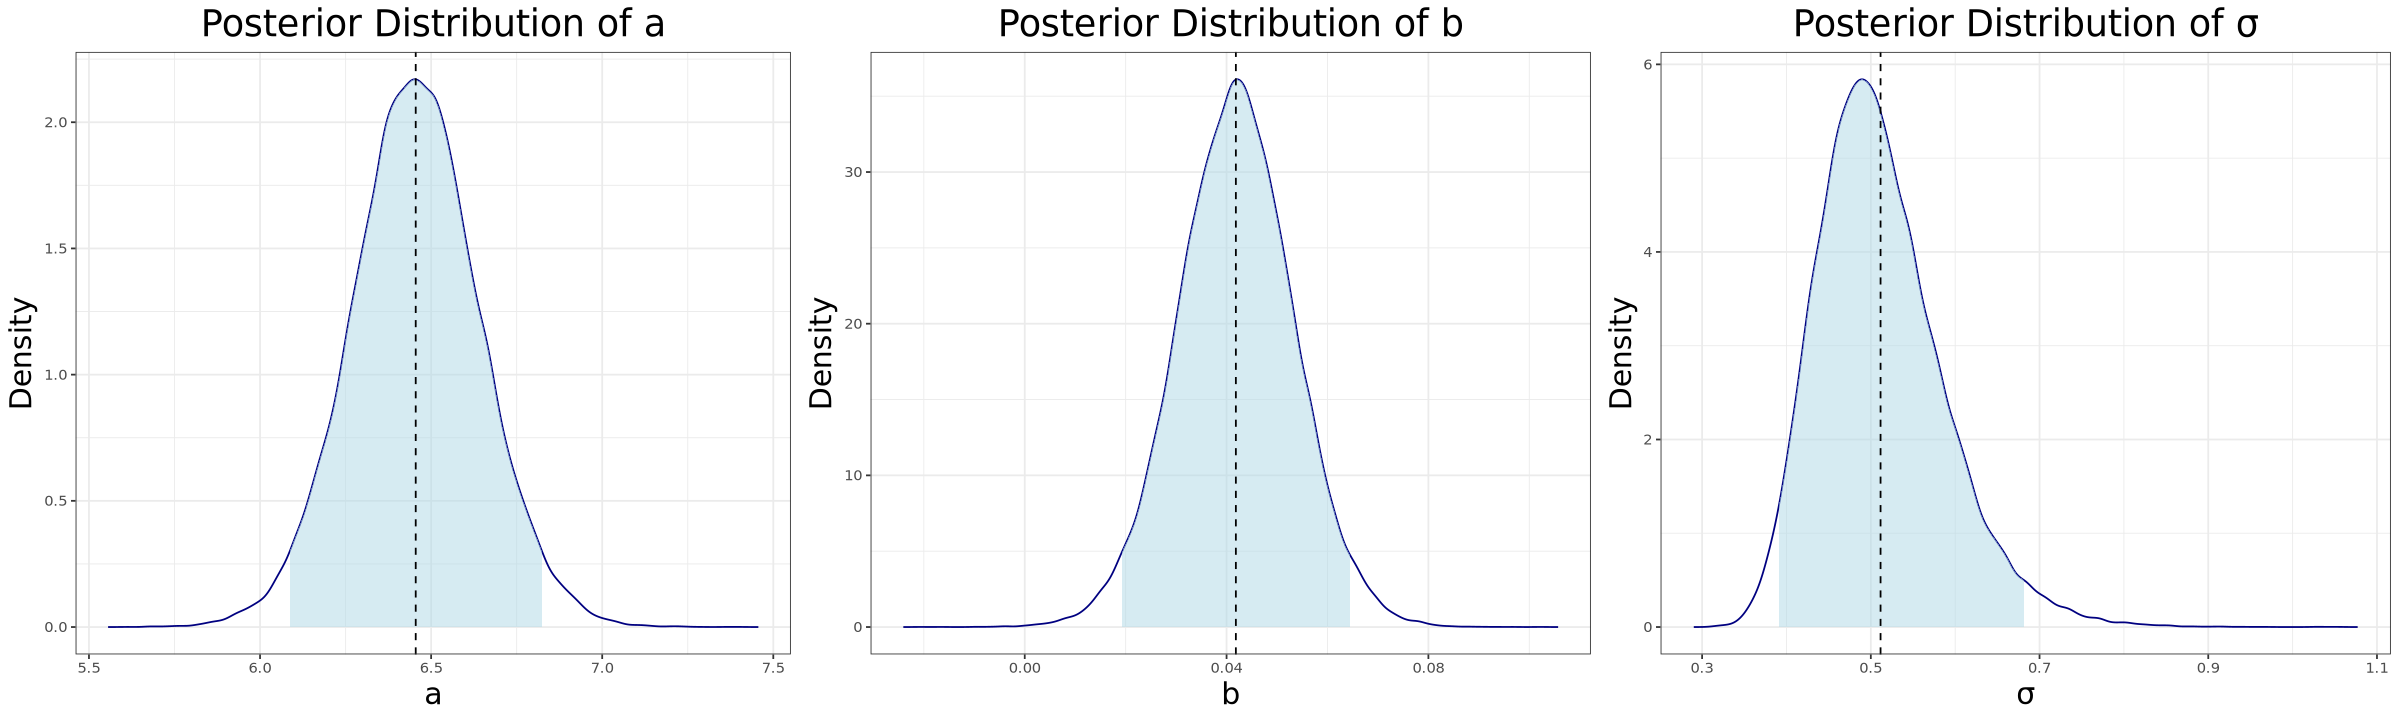

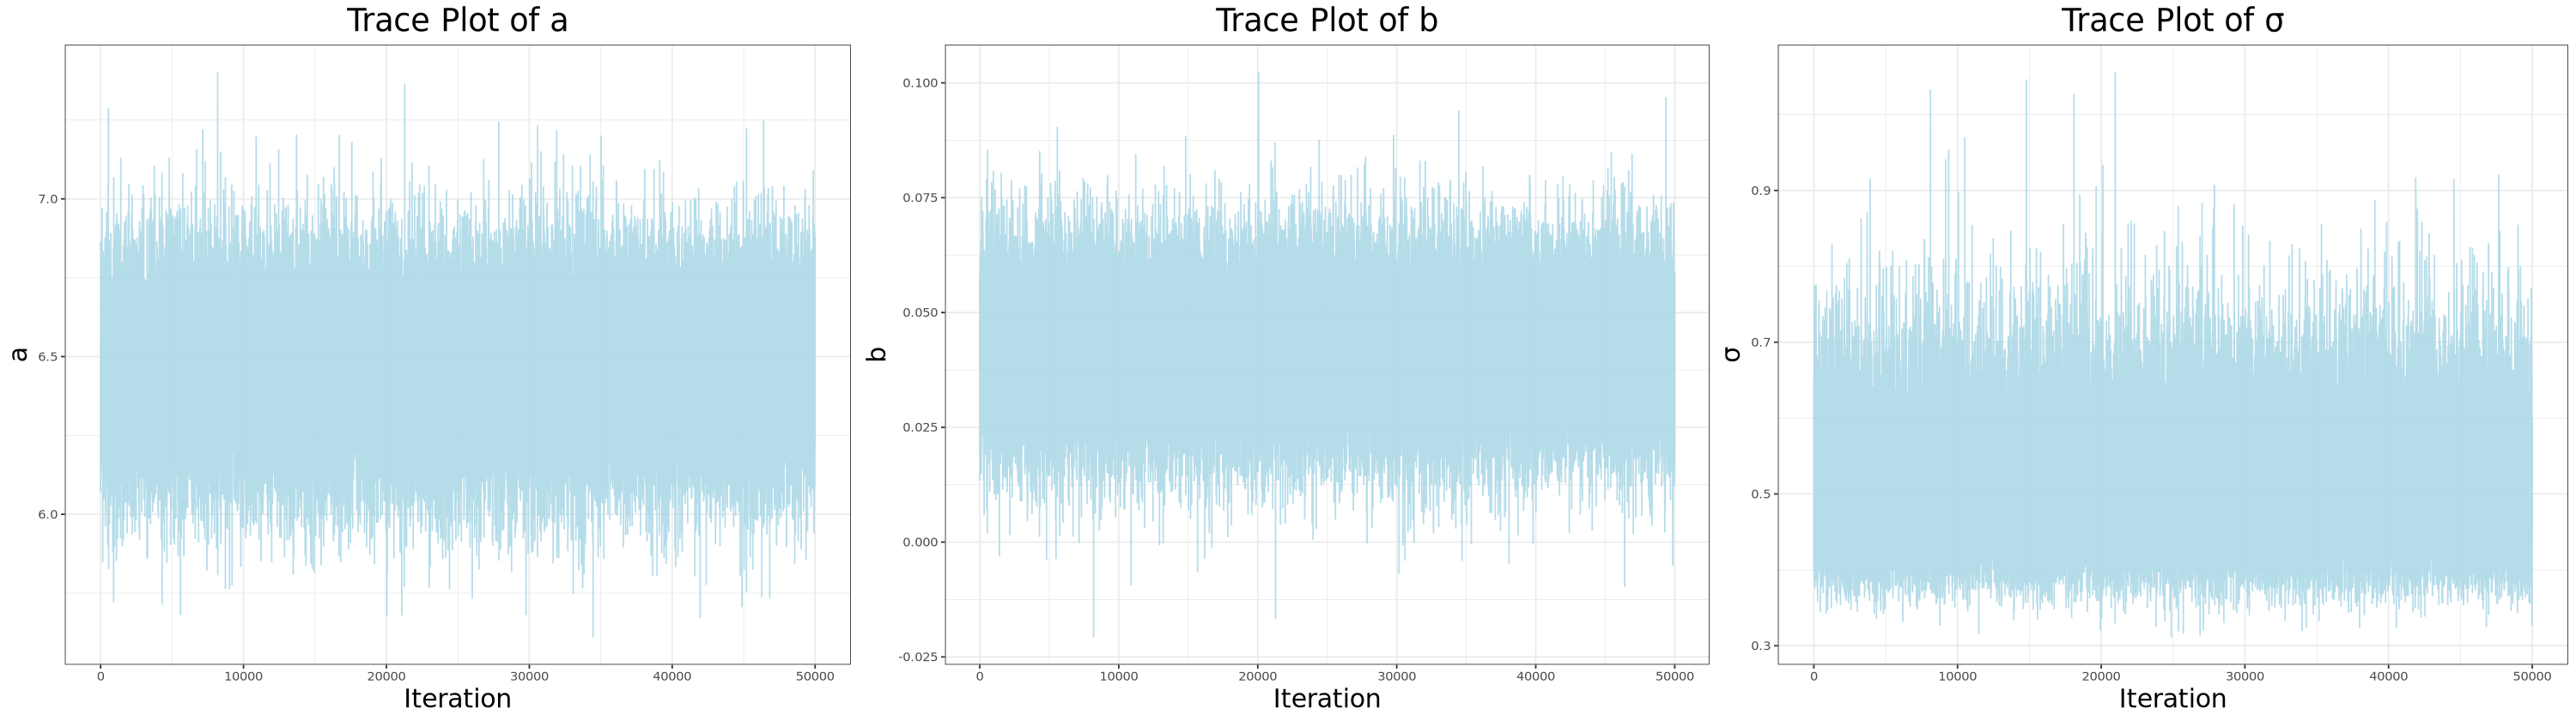

In [18]:
density_plot(lin_chain, 'linear', 'min')
trace_plot(lin_chain, 'linear', 'min')

Once the regression parameter distribution is obtained, we can now try to determine which model best describes the data, given the previous assumption that the likelihood of the data for both models follows a normal distribution, we can set up a hypothesis test based on the likelihood ratio.

### Likelihood ratio test

Given a statistical model $M(\theta)$ with the parameter space $\Theta$, we set the null htpotesis $H_0$ to state that the model parameters for the data are a subset of the parameter space $\theta_0 \in \Theta_0 \subset \Theta$. The likelihood ratio test in his logarithmic form for the null hypothesis is given by :

- $\lambda_{LR} = -2 [ \log\mathcal{L}(M_{\theta}) -  \log\mathcal{L}(M_{\theta_0})]$

In our case $M_{\theta}$ is the linear model and $M_{\theta_0}$ the constant one, the parameter space that we are considering are $\theta_0 = \{ a, \sigma\}$ and $\theta = \{a,b, \sigma\}$. Thanks to the Wilk's theorem the distribution of the test when $H_0$ is true converges asymptotically to a $\chi^2$ distribution with one degree of freedom.
This hypotesis test can tell us if the data reflect or not a linear description.

\begin{cases}
H_0: M = \mathcal{N}(\mu = a, \sigma) \\
H_1: M = \mathcal{N}(\mu = a + bx, \sigma)
\end{cases}



Test's statistic (D): 9.032123 
Degrees of freedom (df): 1 
p-value: 0.002652762 


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


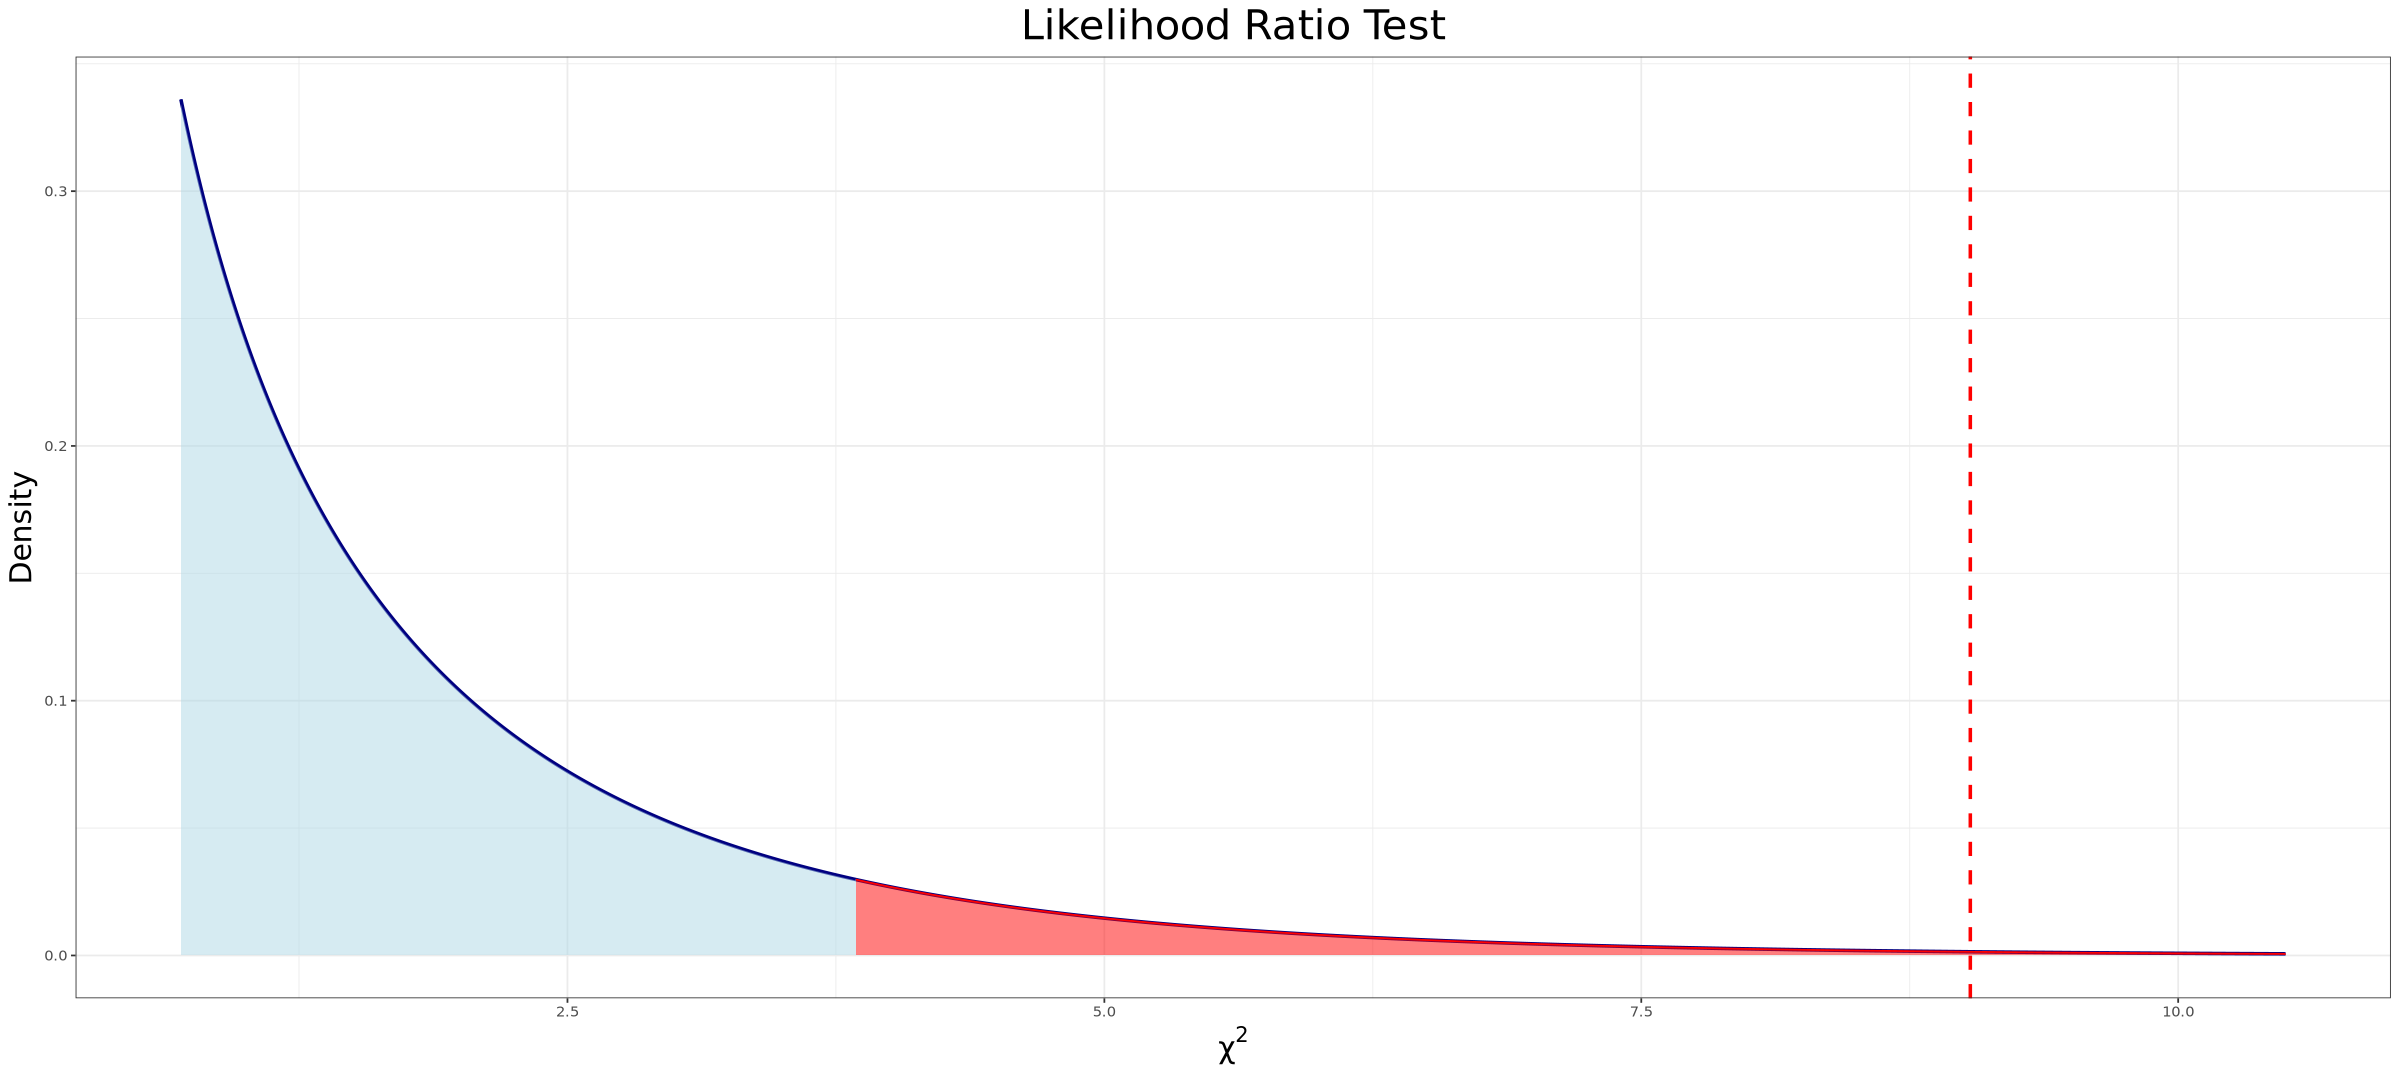

In [16]:
linear_likelihood <- get_model_likelihood(lin_chain, yearly_dataset, type = 'linear',temp = 'ava')
constant_likelihood <- get_model_likelihood(const_chain, yearly_dataset, type = 'constant', temp = 'ava')

log_likelihood_ratio <-   2 * ( linear_likelihood - constant_likelihood)
degree_freedom <- 1
p_value <- pchisq(log_likelihood_ratio, df = degree_freedom, lower.tail = FALSE)

cat("Test's statistic (D):", log_likelihood_ratio, "\n")
cat("Degrees of freedom (df):", degree_freedom, "\n")
cat("p-value:", p_value, "\n")

x <- seq(0.7, 10.5, length.out = 10000)
y <- dchisq(x, degree_freedom)
chi_95 <- qchisq(0.95, df = degree_freedom)

data <- data.frame(x = x, y = y)
options(repr.plot.width = 20, repr.plot.height = 9)

p<-ggplot(data, aes(x = x, y = y)) +
  geom_line(color = "navy", size = 1) +
  geom_vline(xintercept = log_likelihood_ratio, color = "red", linetype = 2, size = 1) +
  geom_area(data = subset(data, x >= chi_95), aes(x = x, y = y), fill = "red", alpha = 0.5, color = 'red') +
  geom_area(data = subset(data, x <= chi_95), aes(x = x, y = y), fill = "lightblue", alpha = 0.5, color = 'navy') +
  labs(title = "Likelihood Ratio Test",
       x = expression(chi^2),
       y = "Density")+
  theme_bw() +
  theme(plot.title = element_text(size = 25, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))
p

The p-value is not within the acceptance region $\alpha = 5\%$, so we must reject the null hypothesis. We then continue the analysis by considering the evolution of the yearly temperature as an increasing linear trend.

## Geographical Correlation

For further analysis, we want to examine the correlation by including geographical information. First, we can create a scatter plot of the yearly temperatures for different stations. Then, we can perform a Pearson correlation test across these stations.

`summarise()` has grouped output by 'year_only'. You can override using the `.groups` argument.


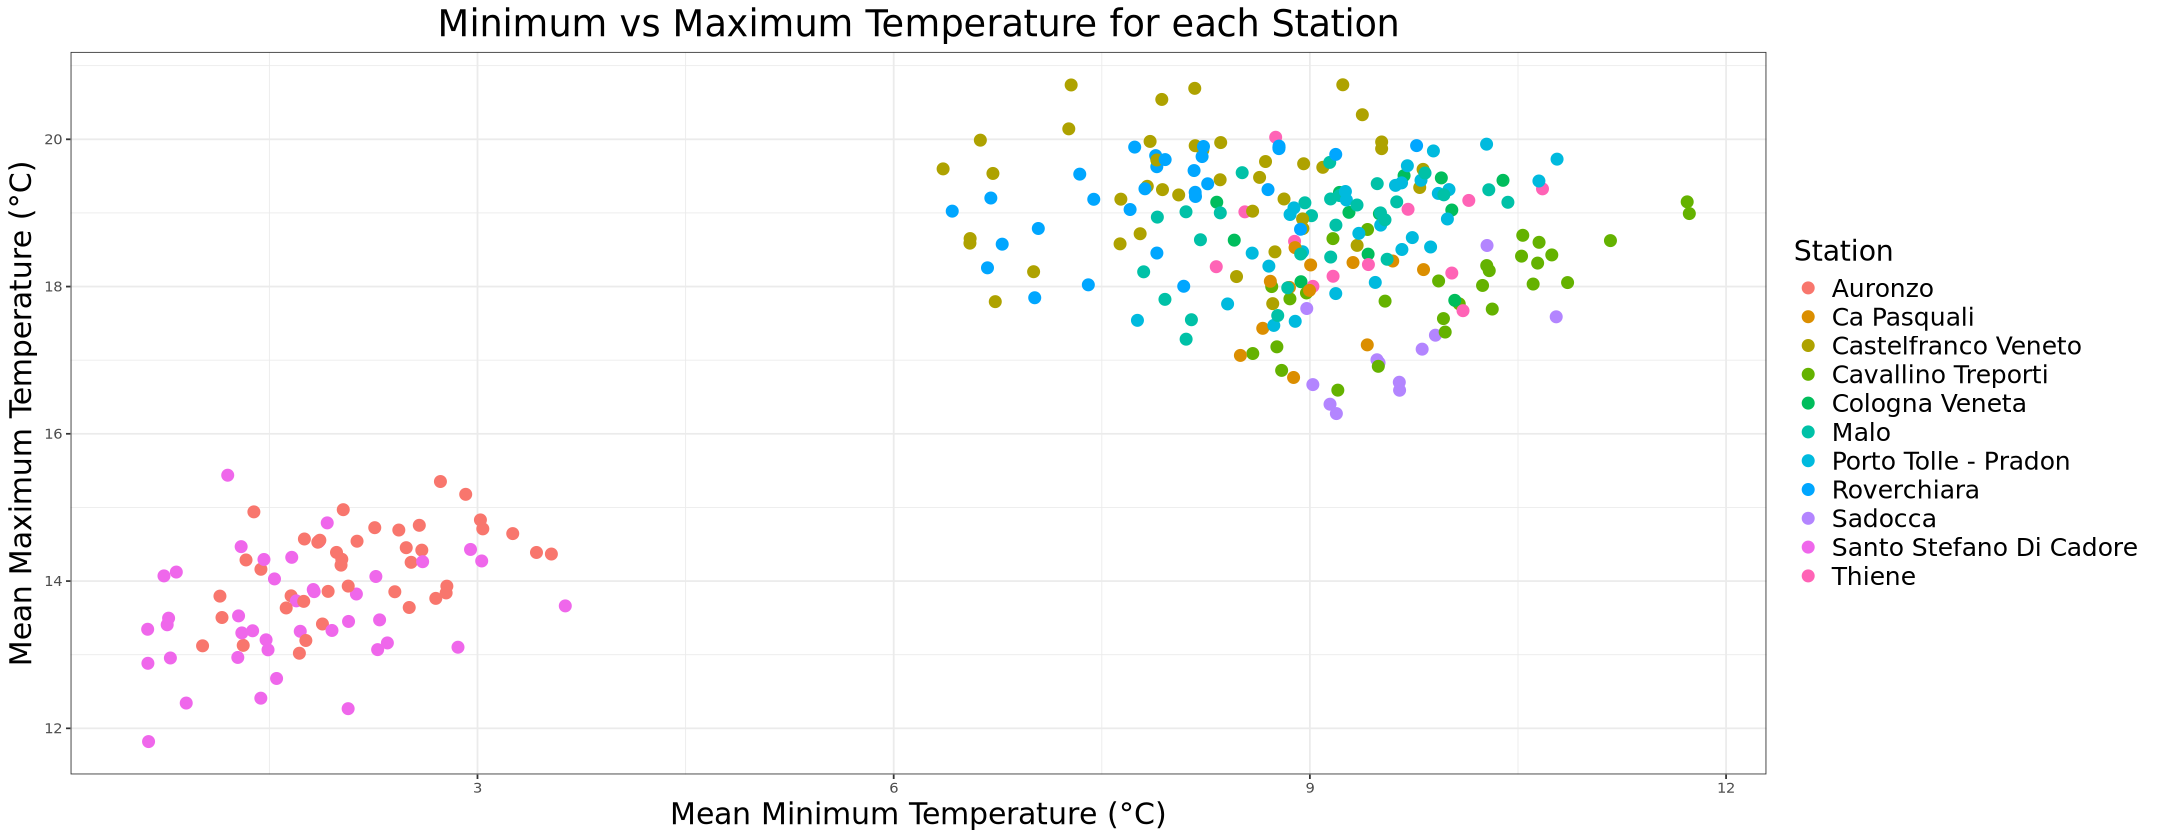

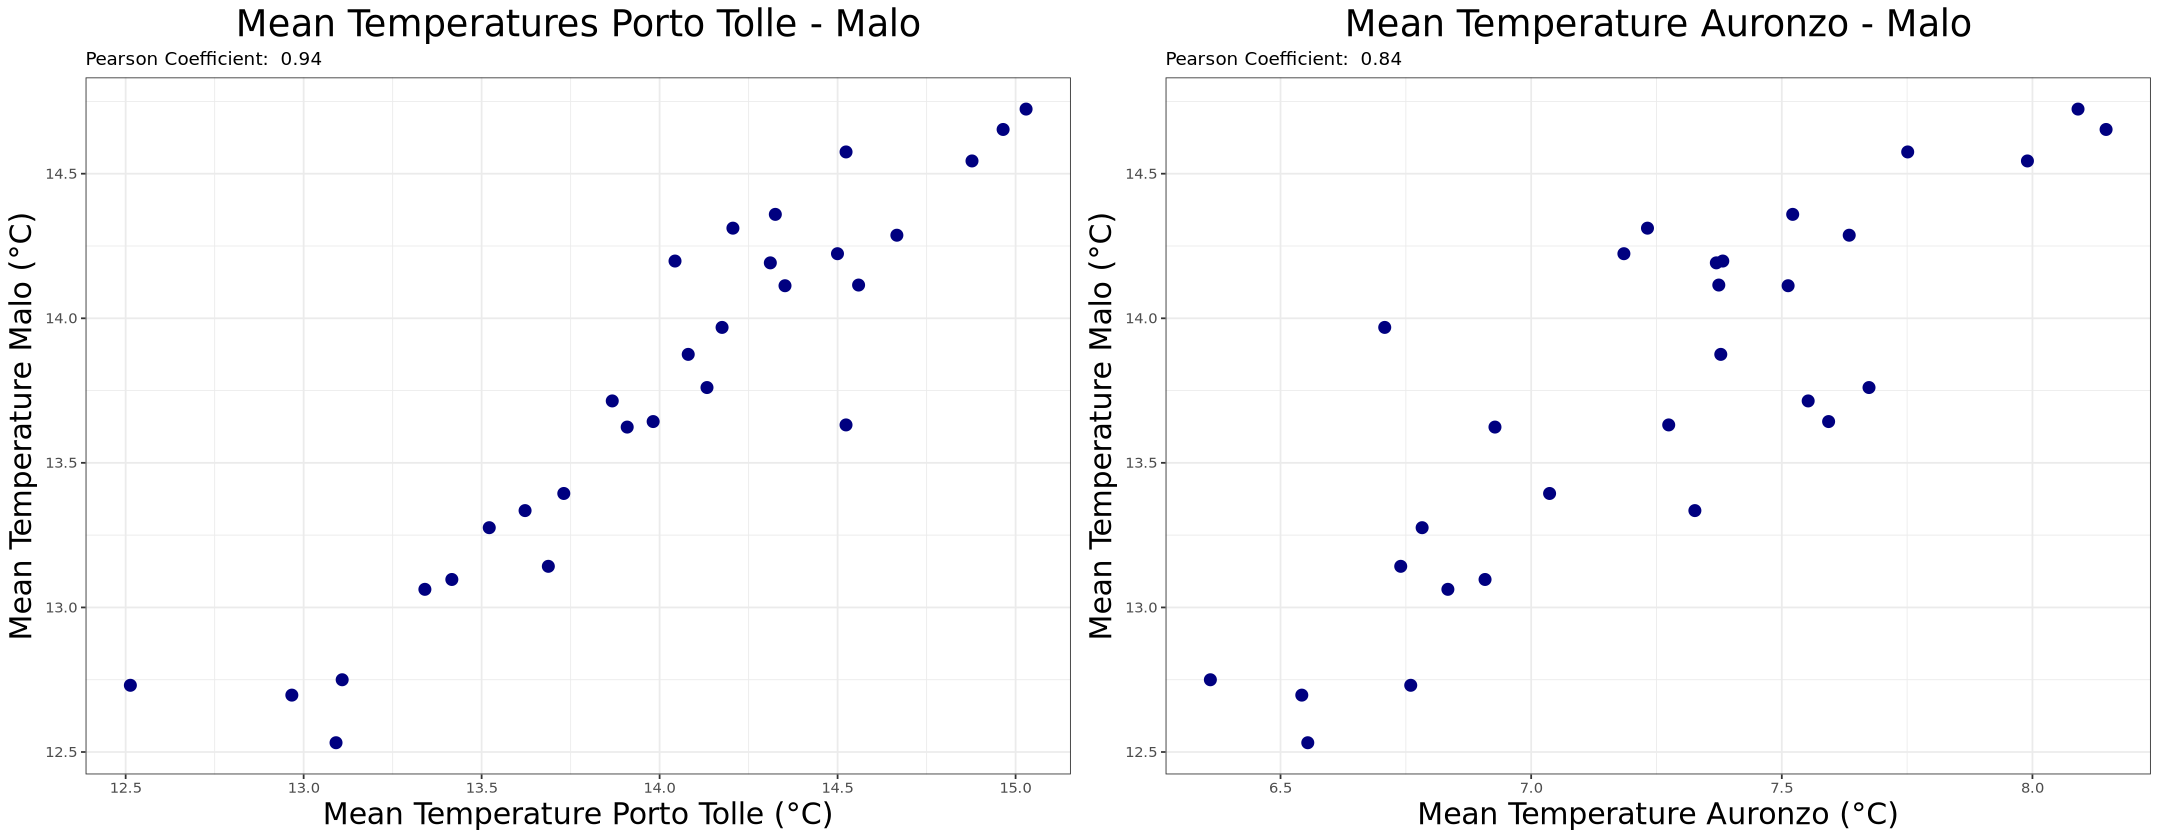

In [19]:

city_dataset <- daily_dataset |>
  group_by(year_only, file) |>
  summarise(MIN_mean = mean(TMIN, na.rm = TRUE),
            MED_mean = mean(TMED, na.rm = TRUE),
            MAX_mean = mean(TMAX, na.rm = TRUE))


porto_tolle <- city_dataset |> filter(file == 'Porto Tolle - Pradon')
malo <- city_dataset |> filter(file == 'Malo')
auronzo <- city_dataset |> filter(file == 'Auronzo')
city_dataset['file'][[1]]<-str_to_title(city_dataset['file'][[1]])
city_dataset['file'][[1]]<-str_replace(city_dataset['file'][[1]],"S. ","Santo ")

corr_df1 <- data.frame(porto_tolle, malo)
corr_df2 <- data.frame(auronzo, malo)

options(repr.plot.width = 18, repr.plot.height = 7)

ggplot(city_dataset, aes(x = MIN_mean, y = MAX_mean, color = file)) +
  geom_point(size = 3) +
  labs(
    title = "Minimum vs Maximum Temperature for each Station",
    x = "Mean Minimum Temperature (°C)",
    y = "Mean Maximum Temperature (°C)",
    color = "Station"
  ) +
  theme_bw() +
  theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))


correlation_pearson <- cor(porto_tolle$MED_mean, malo$MED_mean, method = "pearson")
conf1<-ggplot(corr_df1, aes(x = MED_mean, y = MED_mean.1)) +
  geom_point(size = 3, color = 'navy') +
  labs(
    title = "Mean Temperatures Porto Tolle - Malo",
    subtitle = paste("Pearson Coefficient: ", round(correlation_pearson, 2)),
    x = "Mean Temperature Porto Tolle (°C)",
    y = "Mean Temperature Malo (°C)"
  ) +
  theme_bw() +
  theme(plot.title = element_text(size = 22, hjust = 0.5,color=),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))

correlation_pearson <- cor(auronzo$MED_mean, malo$MED_mean, method = "pearson")
conf2<-ggplot(corr_df2, aes(x = MED_mean, y = MED_mean.1)) +
  geom_point(size = 3, color = 'navy') +
  labs(
    title = "Mean Temperature Auronzo - Malo",
    subtitle = paste("Pearson Coefficient: ", round(correlation_pearson, 2)),
    x = "Mean Temperature Auronzo (°C)",
    y = "Mean Temperature Malo (°C)"
  ) +
  theme_bw() +
  theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))

grid.arrange(conf1,conf2, 
             ncol = 2, nrow = 1)

The first plot clearly tells us that the mountains temperatures cluster in a different area with respect to all the other, as is expected.
If we try to compare the mean temperatures between a station in a mountain area and one slightly below we get a poorer Pearson correlation coefficient than doing the same between the same medium altitude station and a low altitude one. It is also evident by how spread the two plots are around the diagonal, with the lower coefficient one being wider.

## **Annual Difference Evolution Analysis**

We will now analyze the evolution of the annual temperature difference, defining each difference as the one between the current year and the one of the past four years. This will be done by performing a new linear regression to compare the results with the information presented in the *'Rapporto sugli indicatori di impatto dei cambiamenti climatici - 2021'*

The information provided from the documenti is: *'la variazione della temperatura media dal 1981 al 2019 è di +0,38 ± 0,05°C/10 anni; il rateo di variazione della temperatura massima (+0,42 ± 0,06) è maggiore di quello della temperatura minima (+0,34 ± 0,04°C/10 anni)'*

- $\Delta T_{max} : 0,42 ± 0,06$ °C/10 years
- $\Delta T_{min} : 0,34 ± 0,04$ °C/10 years
- $\Delta T_{ava} : 0,38 ± 0,05$ °C/10 years

year_only,MIN_mean,MED_mean,MAX_mean,x_fit
<dbl>,<dbl>,<dbl>,<dbl>,<int>
1993,6.279188,11.29433,16.70935,1
1997,6.528919,11.82113,17.52378,2
2001,6.674016,11.79522,17.37981,3
2005,6.042278,10.82510,16.27128,4
2009,7.212099,12.08863,17.65046,5
2013,7.549836,11.98275,17.08315,6
2017,6.933232,11.98327,17.81874,7
2021,6.750020,11.72077,17.39425,8


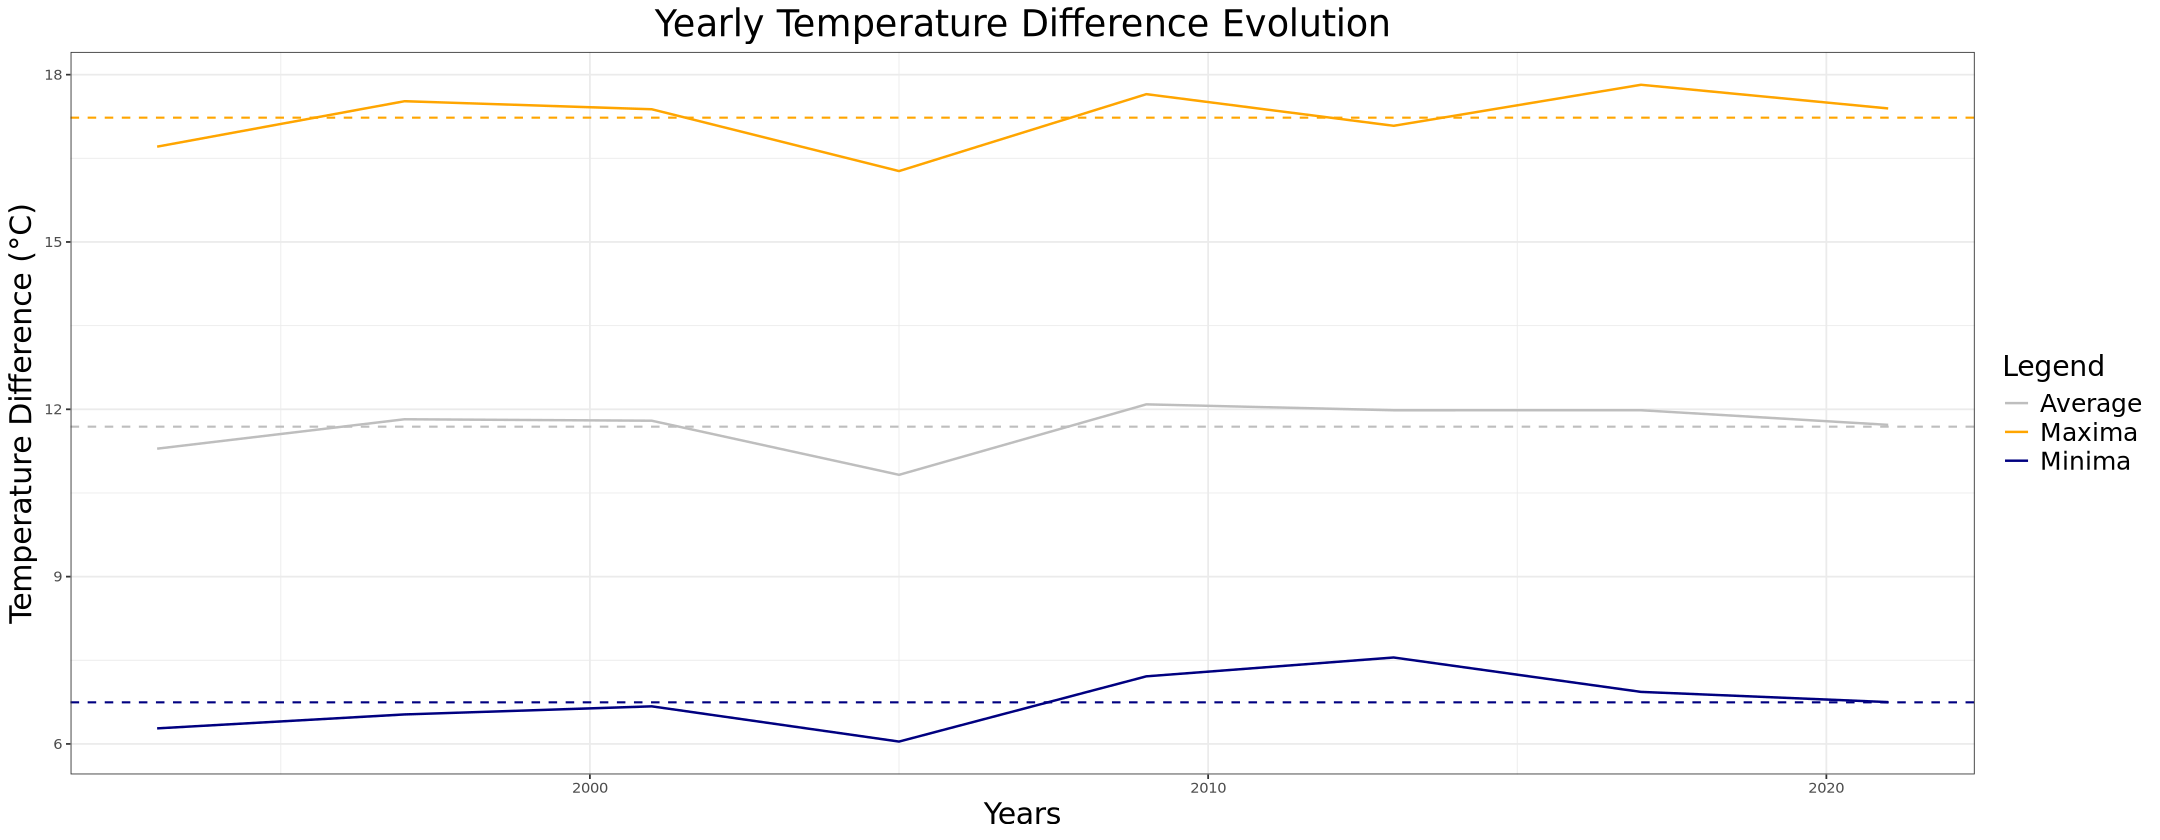

In [20]:
filtered <- yearly_dataset %>%
  filter((year_only - min(year_only))%% 4 == 0) |> mutate(x_fit = 1:length(year_only))
(filtered)

options(repr.plot.width = 18, repr.plot.height = 7)
p_y <- ggplot(data = filtered) +
  geom_line(aes(x = year_only, y = MED_mean, color = 'Average'), group = 1, linewidth = 0.7) +
  geom_hline(aes(yintercept= mean(MED_mean)), color = 'gray', linewidth = 0.6, linetype = 2)+
  geom_line(aes(x = year_only, y = MIN_mean, color = 'Minima'), group = 1, linewidth = 0.7) +
  geom_hline(aes(yintercept= mean(MIN_mean)), color = 'navy', linewidth = 0.6, linetype = 2)+
  geom_line(aes(x = year_only, y = MAX_mean, color = 'Maxima'), group = 1, linewidth = 0.7) +
  geom_hline(aes(yintercept= mean(MAX_mean)), color = 'orange', linewidth = 0.6, linetype = 2)+  
  scale_color_manual(name = 'Legend', values = c('Minima' = 'navy', 'Maxima' = 'orange', 'Average' = 'gray')) +
  labs(title = 'Yearly Temperature Difference Evolution',
       x = 'Years',
       y = 'Temperature Difference (°C)') +
  theme_bw() +
  theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))
p_y


We now fit the temperature difference trends with a linear model using *rjags* as before.

In [21]:
lin_chain <- regression(filtered, lin_model_file, lin_pars)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 24
   Unobserved stochastic nodes: 9
   Total graph size: 104

Initializing model



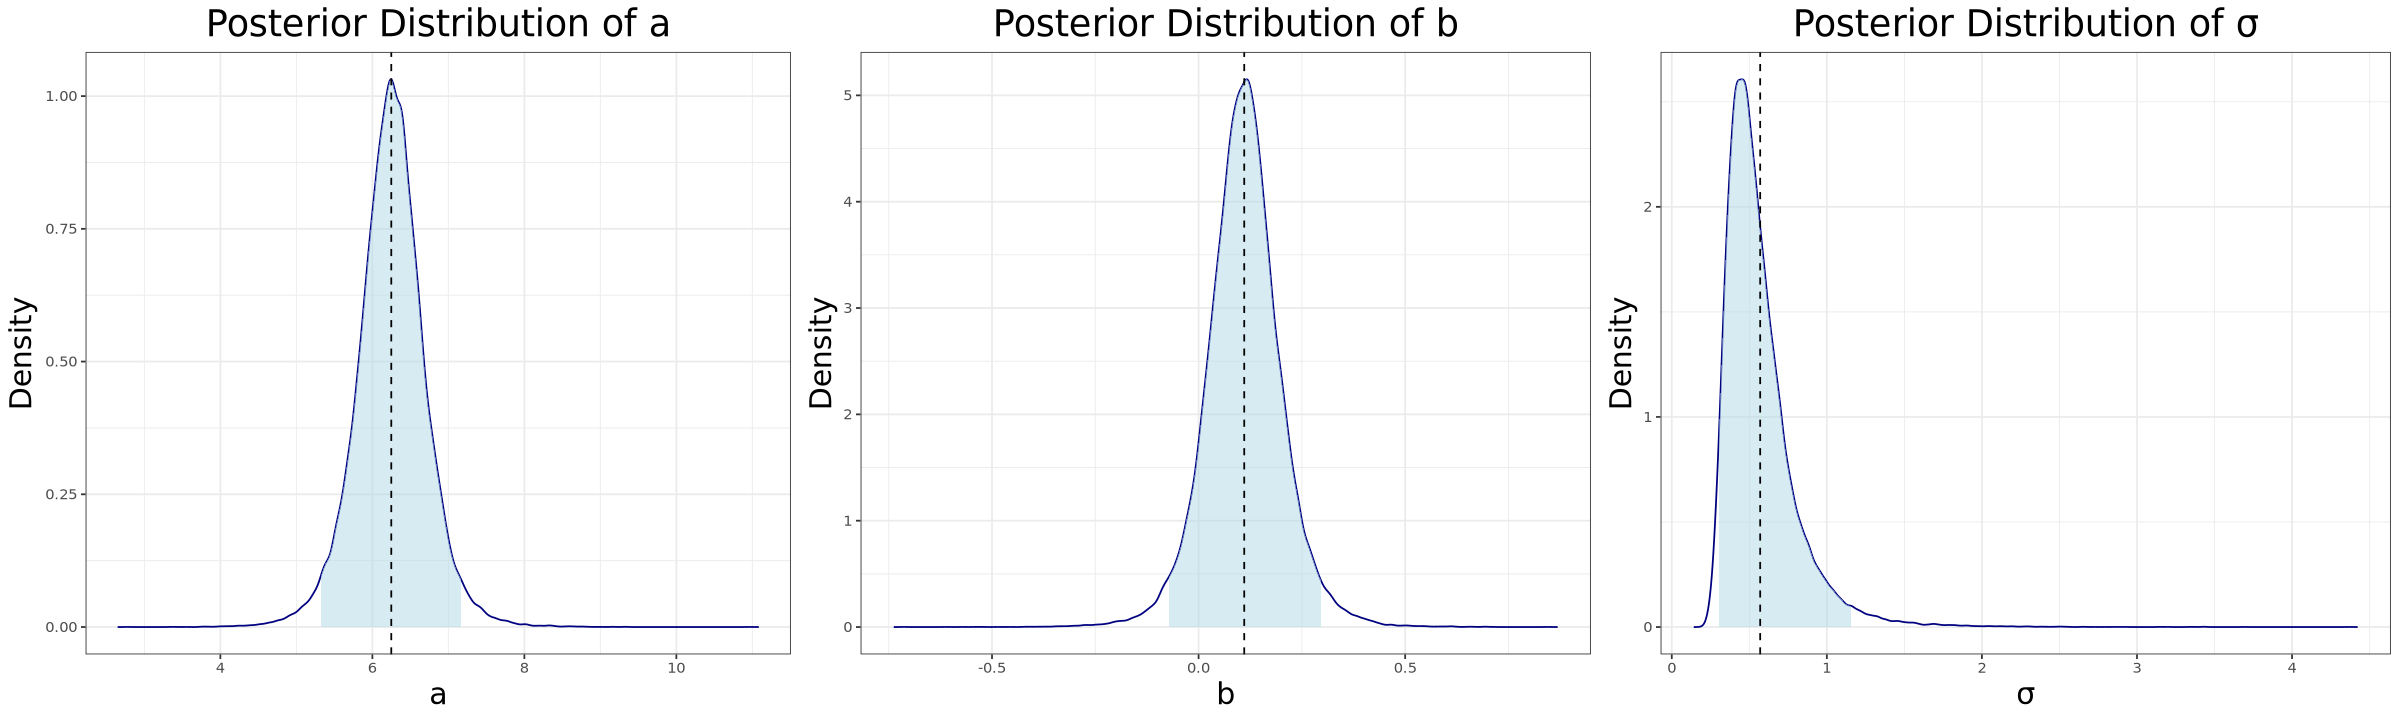

In [22]:
density_plot(lin_chain, 'linear', 'min')

## **Comparing SNPA to our regression**

We want now to compare the values we infer from the montecarlo process with the one obtained in the SNPA document. Since the posterior distribution of the parameter isn't anilitical we can't perform any classical test analysis, we set our null hypotesis $H_0$ to state that the value provided in the report is coherent with the one obtained by the regression, more formally:

$\left\{\begin{array}{rl}
H_0 : b \in [\Delta T_{snpa} - k, \Delta T_{snpa} + k]\\
H_0 : b \not\in [\Delta T_{snpa} - k, \Delta T_{snpa} + k]
\end{array}
\right.$

The probability of the null hypotesis correspond to the area above the confidential region provided by SNPA so:


$P(H_0 | \Delta T_{snpa}, k, b) = P(b \in [\Delta T_{snpa} - k, \Delta T_{snpa} + k]) = \int_{\Delta T_{snpa} - k}^{\Delta T_{snpa} + k} p(b') db'$

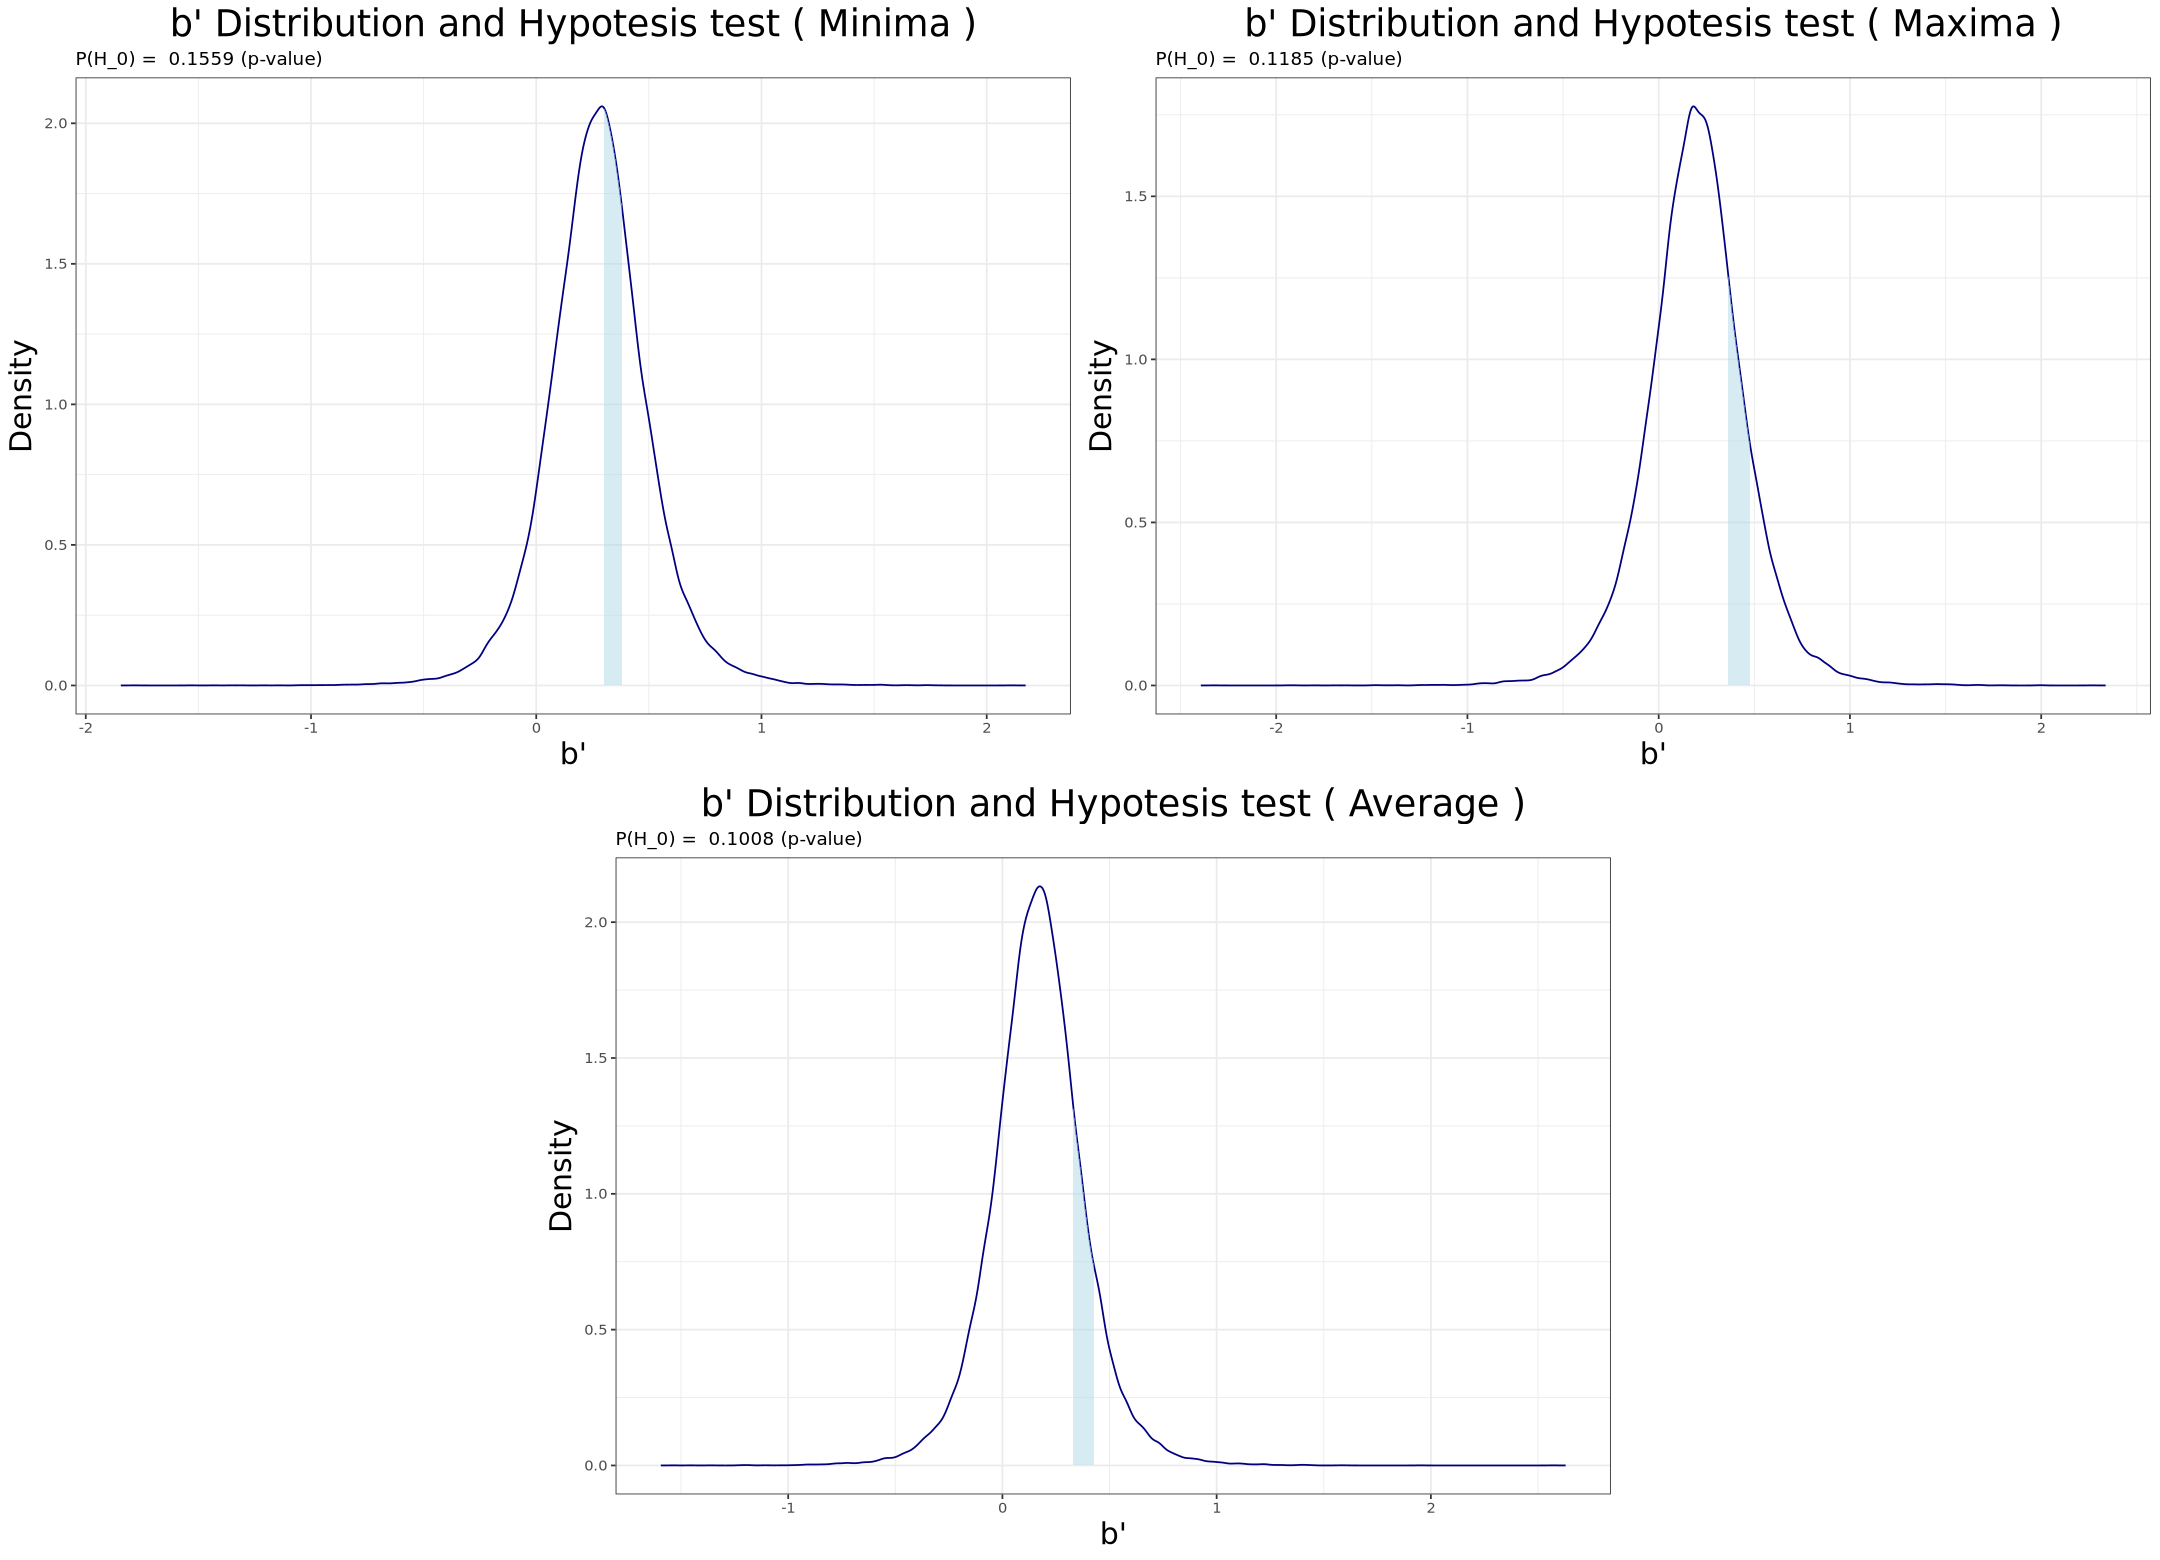

In [23]:
snpa_htest <- function(chain, temp){

    chain_df <- as.data.frame( as.mcmc(chain))

    if(temp == 'max'){
        snpa <- list( mu = 0.42, k = 0.06 )
        str<-'Maxima'
    }
    if(temp == 'ava'){
        snpa <- list( mu = 0.38, k = 0.05 )
        str<-'Average'
    }
    if(temp == 'min'){
        snpa <- list( mu = 0.34, k = 0.04 )
        str<-'Minima'
    }
    b <- 2.5 * chain_df[[paste('b_', temp, sep = '')]]
    density_b <- density(b, n=2024)

    b_prime_post_x <-   density_b[['x']]
    b_prime_post_y <-   density_b[['y']]

    test_area <- sum(b_prime_post_y[b_prime_post_x >= (snpa[['mu']] - snpa[['k']]) & 
                               b_prime_post_x <= (snpa[['mu']] + snpa[['k']])]) * diff(b_prime_post_x)[1]

    df <- data.frame(x = b_prime_post_x, y = b_prime_post_y)
    options(repr.plot.width = 8, repr.plot.height = 7)
    plot <- ggplot(df, aes(x = x, y = y)) +
        geom_line(color = 'navy') +
        geom_area(data = subset(df, x >= snpa[['mu']]-snpa[['k']] & x <= snpa[['mu']]+snpa[['k']]), aes(x = x, y = y), fill = 'lightblue', alpha = 0.5) +
        labs(title = paste("b' Distribution and Hypotesis test (",str,")"),
             subtitle = paste("P(H_0) = ", round(test_area, 4),'(p-value)'),
             x = "b'",
             y = "Density") +
        theme_bw() +
        theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))
    


    return (plot)
}


p_min<-snpa_htest(lin_chain, temp = 'min')
p_ava<-snpa_htest(lin_chain, temp = 'ava')
p_max<-snpa_htest(lin_chain, temp = 'max')
options(repr.plot.width = 18, repr.plot.height = 13)
grid.arrange(p_min, p_max, p_ava, ncol = 2, nrow = 2, layout_matrix=rbind(c(1,1, 2,2), c(NA, 3, 3, NA)))

All the p-values are well above the acceptance value of *0.05* hence we accept the null hypothesis, namely that our data predictions fall within the SNPA credibility interval.

## ***Forecast* Time Series Analysis**

As a last way to analyze our dataset and to also predict the future trends in temperatures we make use of a dedicated package for time series analysis: *forecast*. This helps us fitting several models to the time serie, in particular *ARIMA* (AutoRegressive Integrate Moving Average):

$y'_t=c+\alpha_1y'_{t-1}+\alpha_2y'_{t-2}+\dots+\alpha_py'_{t-p}+\epsilon_t+\theta_1\epsilon_{t-1}+\theta_2\epsilon_{t-2}+\dots+\theta_q\epsilon_{t-q}$

where $y'_t=y_t-y_{t-1}$ is the differed time serie to correct eventual non stationarities of the mean, $p$ is the number of previous temperatures instances that influences each current temperature (with parameters $\alpha_i$), $q$ is the number of previous temperatures error instances that influences each current temperature (with parameters $\theta_i$), $\epsilon_t$ is white noise and $c$ is a constant.

Since the data doesn't seem non stationary (the mean is pretty stable even if rising) we don't do any initial differing. The next step in fitting such model to our time series is to determining the $(p,d,q)$ parameters; a first approach can be done studying the $ACF$ (AutoCorrelation Function) and $PACF$ (Partial AutoCorrelation Function) plots. The former evaluates the autocorrelation between each temperature instance and the nth previous data (where n is the lag); the latter measures the relationship between $y_t$ and $y_{t−k}$ after removing the effects of lags $1,2,3,…,k−1$.<br>
Now according to the trends we see in these plots we can assess if there is a most probable model of the form *ARIMA*$(0,d,q)$ or *ARIMA*$(p,d,0)$.

In [605]:
ACFPlots<-function(ts_data,type){

options(repr.plot.width = 18, repr.plot.height = 6)
acf<-ggAcf(ts_data,lag=length(ts_data))+labs(title=paste('ACF plot for the yearly',type,'temperatures'))+theme_bw() +
        theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))
pacf<-ggPacf(ts_data,length(ts_data))+labs(title=paste('PACF plot for the yearly',type,'temperatures'))+theme_bw() +
        theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))

grid.arrange(acf,pacf, 
             ncol = 2, nrow = 1)
}

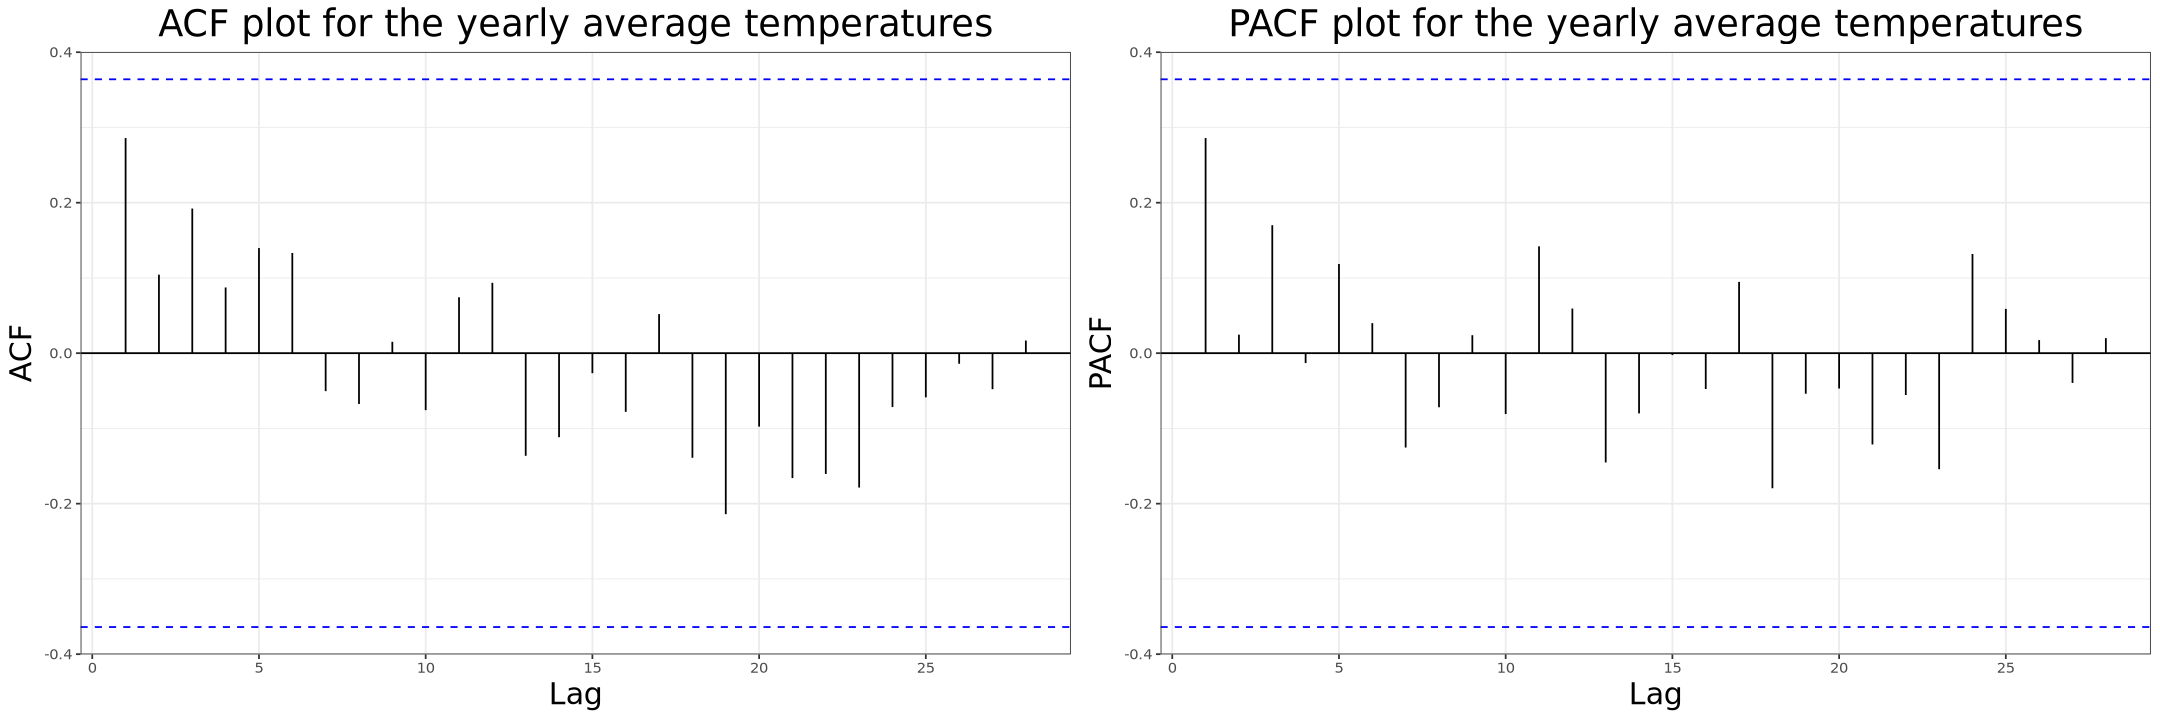

In [606]:
ts_data_mean <- ts(yearly_dataset$MED_mean,start=1993)

ACFPlots(ts_data_mean,'average')

We can see from the blue dotted lines, which represent $\pm 1.92/\sqrt{T}$ with $T$ the length of the series, that most previous temperatures are not much correlated with the current ones as all the correlations in both plots fall inside the white noise window. <br>
The trends seen are not really evident. One could say that there is a cut off in the *ACF* after lag *6* and a slight sinusoidal trend in the *PACF*, which would favor an *ARIMA*$(0,0,6)$ model, but they are not clear enough to lead us blindly towards this direction.

So we proceed with a more systematic process performing a gridsearch over p and q, training the model over the first 80% of the dataset and evaluating the results on the test set (the last 20%). The metric followed during training was to minimize the $AICc$ (corrected Akaike’s Information Criterion) which is defined as:
$$AICc=-2log(L)+2(p+q+k+1)+\frac{2(p+q+k+q)(p+q+k+2)}{T-p-q-k-2}$$
where $L$ is the likelihood of the data, $k=1$ if $c\neq0$ and $k=0$ if $c=0$. The first two term are part of the normal $AIC$ whereas the last term is the correction useful for short time series (like ours). We also implement some restrictions on p and q, particularly setting them to be at least 4 in order to capture trends in the overall time series and not only close to the forecast's origin.

In [539]:
find_best_arima_model <- function(timeseries, iterations) {
    # Divide the series into training and test sets
    n_train <- floor(0.8 * length(timeseries))
    training_set <- timeseries[1:n_train] 
    test_set <- timeseries[(n_train + 1):length(timeseries)]  

    # Initialize variables to store the best model
    best_model <- NULL
    best_rmse <- Inf 
    best_aic <- Inf  
    best_params <- NULL
    
    #set.seed(123)
    
    # Iterate to find the best ARIMA model
    for (i in 1:iterations) {
        p <- sample(4:15, 1)
        d <- sample(2, 1)
        q <- sample(4:15, 1)
        model <- Arima(training_set, order = c(p, d, q),include.mean = TRUE)
        forecasts <- forecast(model, h = length(test_set))
        
        # Calculate RMSE
        rmse <- accuracy(forc,test_set)[2,2]
        aic <- AICc(forecasts$model)

        # Update best model if current model is better
        if (aic <= best_aic &&rmse<=best_rmse){
            best_model <- model
            best_rmse <- rmse
            best_aic <- aic
            best_params <- c(p,d,q)
        }
    }
    
    # Train the best model on the entire dataset
    final_model <- Arima(timeseries, order = best_params)

    print(summary(final_model))
    #plot_forecast(timeseries, forecast = forecasts, test = TRUE)
    
    return(list(best_model = final_model, training = training_set, test = test_set, best_params = best_params))
}

In [548]:
options(warn=-1)
best_arima_mean <- find_best_arima_model(timeseries = ts_data_mean, iterations = 100)

Series: timeseries 
ARIMA(12,1,9) 

Coefficients:
          ar1      ar2      ar3      ar4     ar5     ar6     ar7     ar8
      -0.1568  -0.8703  -0.0360  -0.0974  0.6362  0.3694  0.4557  0.1908
s.e.   0.3746   0.3828   0.4635   0.3551  0.4421  0.3663  0.4061  0.3773
         ar9     ar10    ar11    ar12      ma1     ma2      ma3      ma4
      0.2908  -0.2065  0.2274  0.1888  -0.3279  0.5505  -0.2249  -0.6307
s.e.  0.3451   0.4361  0.2965  0.4113   0.5449  0.5207   0.6926   0.6013
          ma5      ma6     ma7      ma8     ma9
      -0.7139  -0.3922  0.3734  -0.4767  0.8898
s.e.   0.4973   0.5964  0.6754   0.5288  0.5412

sigma^2 = 0.2694:  log likelihood = -13.13
AIC=70.26   AICc=272.66   BIC=99.57

Training set error measures:
                     ME      RMSE     MAE       MPE     MAPE      MASE
Training set 0.05860554 0.2550048 0.18948 0.4340783 1.601728 0.3863258
                    ACF1
Training set -0.04163441


The best model appears to be an *ARIMA(12,1,9)*. We now check the residuals of such best model.


	Ljung-Box test

data:  Residuals from ARIMA(12,1,9)
Q* = 10.628, df = 3, p-value = 0.01392

Model df: 21.   Total lags used: 24



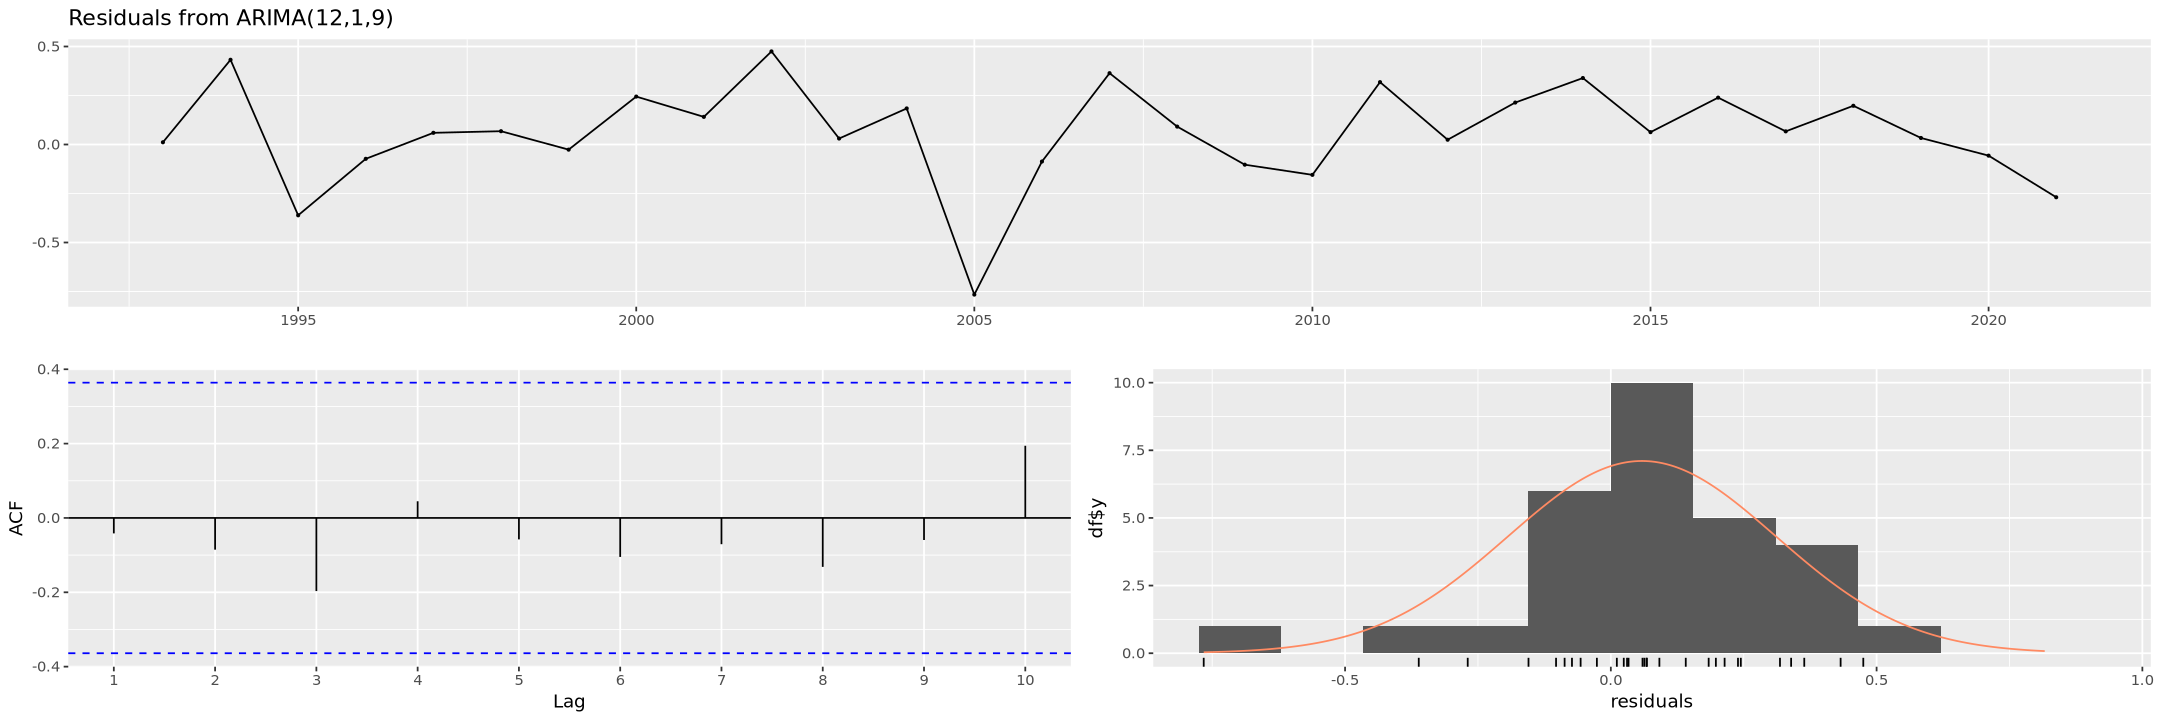

In [627]:
checkresiduals(best_arima_mean$best_model, plot = TRUE)

All the residuals fall clearly inside the white noise window so the model is well fitting. We proceed with making a 20 years forecast into the future average temperature.

In [618]:
prediction <- forecast(best_arima_mean$best_model,h = 20)
total_growth<-prediction[[4]][20]-prediction[[4]][1]
annual_growth<-total_growth/20
cat('Total average temperature growth: ',round(total_growth,2),'\n')
cat('Annual average temperature growth: ',round(annual_growth,2))

Total average temperature growth:  1.19 
Annual average temperature growth:  0.06

In [603]:
plot_forecast_non_stationary <- function(timeseries, forecast) {

  years<-1993:2021
  forcyears<-2021:(2021+length(forecast[[4]])-1)
  df <- data.frame(x = years, series = timeseries)
  df_forecast<-data.frame(x = forcyears, series = forecast[[4]], seriestop80=forecast[[6]][,1],seriesbott80=forecast[[5]][,1],seriestop95=forecast[[6]][,2],seriesbott95=forecast[[5]][,2])
  # Creare il grafico
  p_rib <- ggplot(df) +
    geom_line(aes(x = x, y = series), color = 'navy', size = 1) +
    geom_line(data = df_forecast, aes(x = x, y = series), color = 'red', size = 1) +

    geom_ribbon(data = df_forecast, aes(x = x, ymin = seriesbott80, ymax = seriestop80), color = 'red', size = 1,linetype=2, alpha = 0.2, fill = 'lightblue') +
    geom_ribbon(data = df_forecast, aes(x = x, ymin = seriesbott95, ymax = seriestop95), color = 'red', size = 1,linetype=2, alpha = 0.2, fill = 'lightblue') +

    #scale_x_continuous(breaks = 1:length(years), labels = years) +
    labs(
        title='Forecasting Average Temperature',
        x='years',
        y='Temperature (°C)'
    )+
    theme_bw() +
        theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))
    print(p_rib)
    
    p <- ggplot(df) +
    geom_line(aes(x = x, y = series), color = 'navy', size = 1) +
    geom_line(data = df_forecast, aes(x = x, y = series), color = 'red', size = 1) +
    
    #scale_x_continuous(breaks = 1:length(years), labels = years) +
    labs(
        title='Forecasting Average Temperature',
        x='years',
        y='Temperature (°C)'
    )+
    theme_bw() +
        theme(plot.title = element_text(size = 22, hjust = 0.5),
        axis.title = element_text(size = 18),
        legend.text = element_text(size = 15),
        legend.title = element_text(size = 17))
  
  print(p)

}

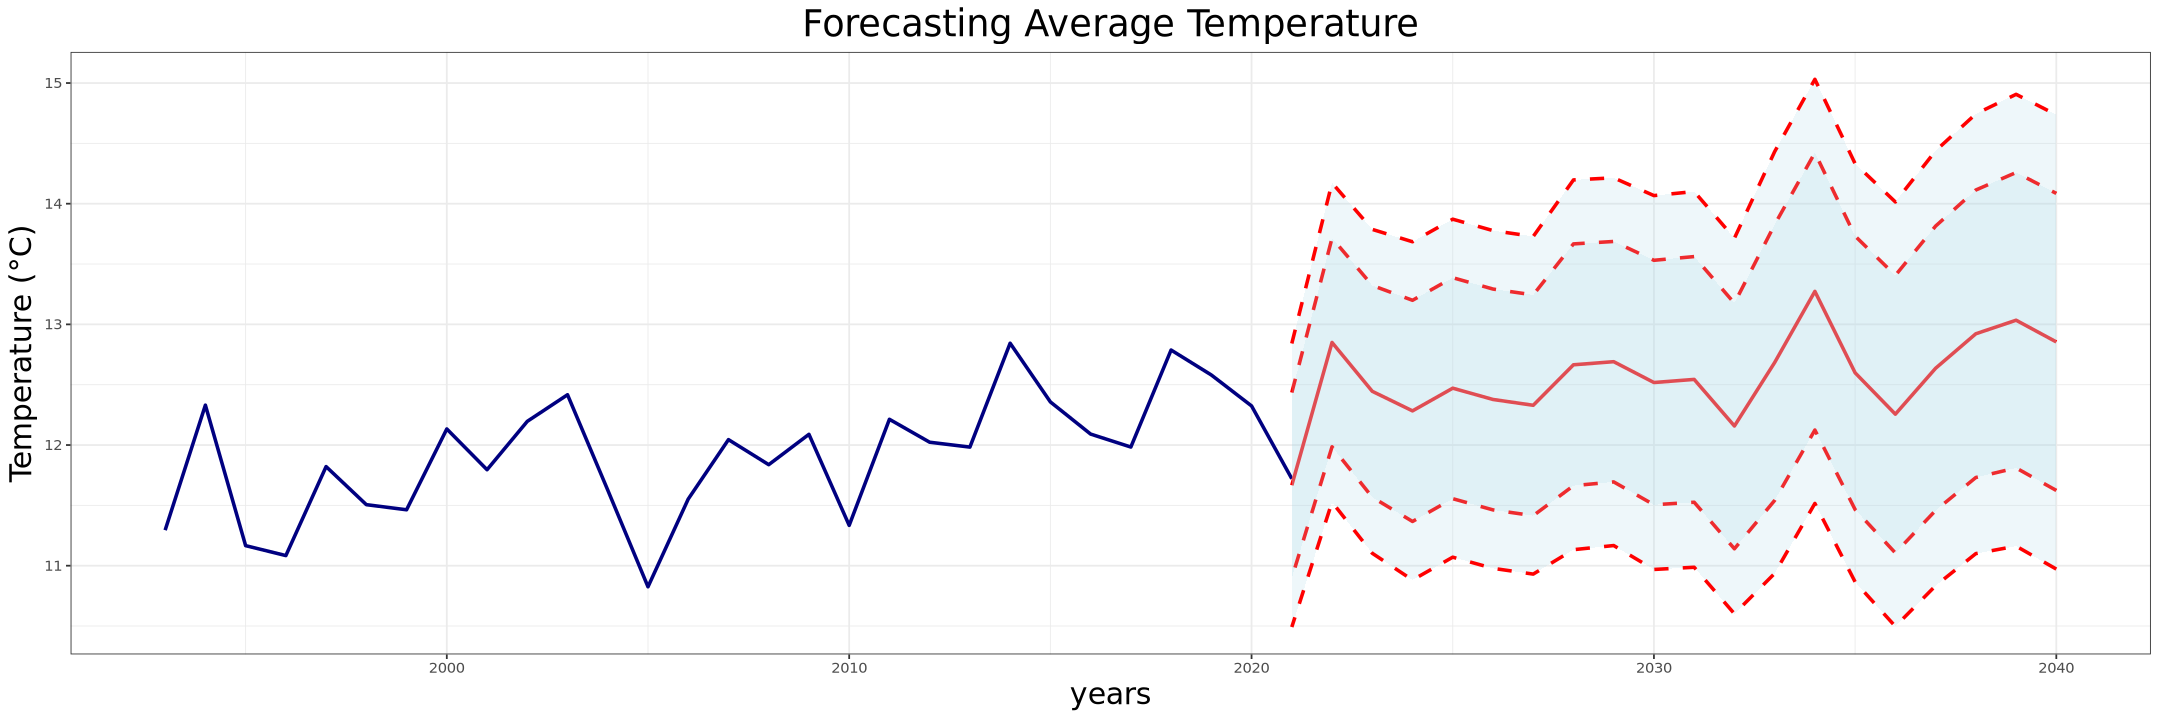

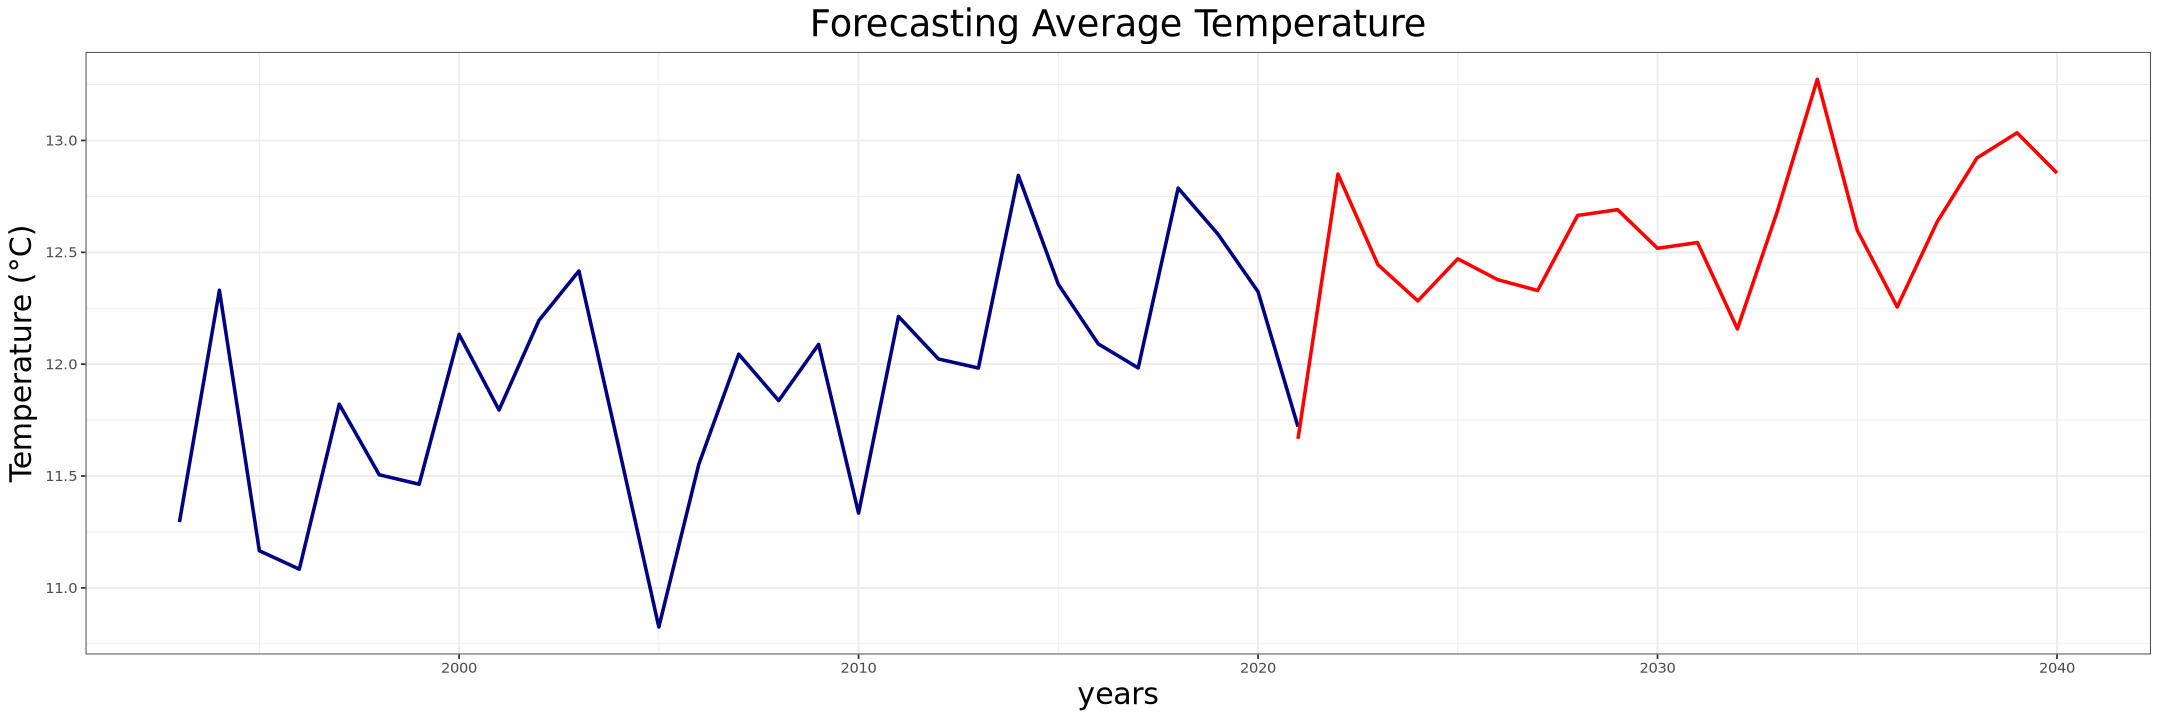

In [604]:
plot_forecast_non_stationary(yearly_dataset$MED_mean,forecast=prediction)

We can see that the model learned the rising trend and the cyclic features of the time series as well. Both the total and annual growth are in line with the previous predictions.